In [1]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-01-13 11:21:15.387789: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 11:21:15.419524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 11:21:15.419549: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 11:21:15.419565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 11:21:15.425510: I tensorflow/core/platform/cpu_feature_g

# Training (PM2.5)

In [2]:
emis_ctrl_2013_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2013.csv', index_col=0)
emis_ctrl_2013_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2013_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]
# -------------
base_path_2013 = '/home/user/workdir/main/datasets/concentration/2013'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/pm25/2013data/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.3  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
 
# define callback
def scheduler(epoch, lr):
    if epoch < 400: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/pm25/2013data/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-13 11:21:17.861895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20305 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-13 11:21:17.865175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 562 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-13 11:21:17.867865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 562 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-13 11:21:17.869942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 562 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci 

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-13 11:21:45.827488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:21:45.838052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:21:45.860704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:21:45.882875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 11:21:48.525137: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1cc9ec30d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 11:21:48.525169: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 11:21:48.525174: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 11:21:48.52517

3/3 [==============================] - ETA: 0s - loss: 146.3524 INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-01-160.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-01-160.70/assets


3/3 [==============================] - 48s 7s/step - loss: 146.3524 - val_loss: 160.6969 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 134.5856INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-02-160.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-02-160.48/assets


3/3 [==============================] - 9s 5s/step - loss: 134.5856 - val_loss: 160.4791 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 124.9834INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-03-160.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-03-160.33/assets


3/3 [==============================] - 10s 5s/step - loss: 124.9834 - val_loss: 160.3264 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 118.7978INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-04-159.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-04-159.76/assets


3/3 [==============================] - 10s 5s/step - loss: 118.7978 - val_loss: 159.7575 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - ETA: 0s - loss: 114.8765INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-05-158.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-05-158.90/assets


3/3 [==============================] - 10s 5s/step - loss: 114.8765 - val_loss: 158.8979 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 112.1856INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-06-157.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-06-157.77/assets


3/3 [==============================] - 10s 5s/step - loss: 112.1856 - val_loss: 157.7744 - lr: 0.0010
Epoch 7/500
2/3 [===================>..........] - ETA: 0s - loss: 110.2844INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-07-156.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-07-156.46/assets


3/3 [==============================] - 10s 5s/step - loss: 110.2728 - val_loss: 156.4564 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - ETA: 0s - loss: 108.8491INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-08-155.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-08-155.05/assets


3/3 [==============================] - 10s 5s/step - loss: 108.8491 - val_loss: 155.0467 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - ETA: 0s - loss: 107.7610INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-09-153.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-09-153.62/assets


3/3 [==============================] - 10s 5s/step - loss: 107.7610 - val_loss: 153.6158 - lr: 0.0010
Epoch 10/500
2/3 [===================>..........] - ETA: 0s - loss: 106.8617INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-10-152.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-10-152.25/assets


3/3 [==============================] - 10s 5s/step - loss: 106.8379 - val_loss: 152.2462 - lr: 0.0010
Epoch 11/500
3/3 [==============================] - ETA: 0s - loss: 106.0056INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-11-150.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-11-150.94/assets


3/3 [==============================] - 10s 5s/step - loss: 106.0056 - val_loss: 150.9383 - lr: 0.0010
Epoch 12/500
3/3 [==============================] - ETA: 0s - loss: 105.2177INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-12-149.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-12-149.69/assets


3/3 [==============================] - 10s 5s/step - loss: 105.2177 - val_loss: 149.6881 - lr: 0.0010
Epoch 13/500
2/3 [===================>..........] - ETA: 0s - loss: 104.7703INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-13-148.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-13-148.52/assets


3/3 [==============================] - 10s 5s/step - loss: 104.4528 - val_loss: 148.5234 - lr: 0.0010
Epoch 14/500
3/3 [==============================] - ETA: 0s - loss: 103.6943INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-14-147.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-14-147.50/assets


3/3 [==============================] - 10s 5s/step - loss: 103.6943 - val_loss: 147.5006 - lr: 0.0010
Epoch 15/500
3/3 [==============================] - ETA: 0s - loss: 102.9421INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-15-146.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-15-146.66/assets


3/3 [==============================] - 10s 5s/step - loss: 102.9421 - val_loss: 146.6566 - lr: 0.0010
Epoch 16/500
2/3 [===================>..........] - ETA: 0s - loss: 102.4364INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-16-145.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-16-145.92/assets


3/3 [==============================] - 10s 5s/step - loss: 102.1849 - val_loss: 145.9237 - lr: 0.0010
Epoch 17/500
3/3 [==============================] - ETA: 0s - loss: 101.4210INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-17-145.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-17-145.40/assets


3/3 [==============================] - 10s 5s/step - loss: 101.4210 - val_loss: 145.3957 - lr: 0.0010
Epoch 18/500
3/3 [==============================] - ETA: 0s - loss: 100.6428INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-18-145.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-18-145.00/assets


3/3 [==============================] - 10s 5s/step - loss: 100.6428 - val_loss: 144.9987 - lr: 0.0010
Epoch 19/500
3/3 [==============================] - ETA: 0s - loss: 99.8534 INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-19-144.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-19-144.66/assets


3/3 [==============================] - 10s 5s/step - loss: 99.8534 - val_loss: 144.6648 - lr: 0.0010
Epoch 20/500
3/3 [==============================] - ETA: 0s - loss: 99.0574INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-20-144.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-20-144.31/assets


3/3 [==============================] - 9s 4s/step - loss: 99.0574 - val_loss: 144.3132 - lr: 0.0010
Epoch 21/500
3/3 [==============================] - ETA: 0s - loss: 98.2531INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-21-143.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-21-143.98/assets


3/3 [==============================] - 11s 6s/step - loss: 98.2531 - val_loss: 143.9834 - lr: 0.0010
Epoch 22/500
3/3 [==============================] - ETA: 0s - loss: 97.4429INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-22-143.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-22-143.67/assets


3/3 [==============================] - 9s 4s/step - loss: 97.4429 - val_loss: 143.6725 - lr: 0.0010
Epoch 23/500
2/3 [===================>..........] - ETA: 0s - loss: 96.8619INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-23-143.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-23-143.44/assets


3/3 [==============================] - 10s 5s/step - loss: 96.5945 - val_loss: 143.4422 - lr: 0.0010
Epoch 24/500
2/3 [===================>..........] - ETA: 0s - loss: 95.8226INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-24-143.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-24-143.19/assets


3/3 [==============================] - 10s 5s/step - loss: 95.7252 - val_loss: 143.1871 - lr: 0.0010
Epoch 25/500
3/3 [==============================] - ETA: 0s - loss: 94.8303INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-25-142.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-25-142.87/assets


3/3 [==============================] - 10s 5s/step - loss: 94.8303 - val_loss: 142.8716 - lr: 0.0010
Epoch 26/500
3/3 [==============================] - ETA: 0s - loss: 93.9120INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-26-142.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-26-142.48/assets


3/3 [==============================] - 10s 5s/step - loss: 93.9120 - val_loss: 142.4810 - lr: 0.0010
Epoch 27/500
3/3 [==============================] - ETA: 0s - loss: 92.9919INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-27-142.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-27-142.07/assets


3/3 [==============================] - 10s 5s/step - loss: 92.9919 - val_loss: 142.0710 - lr: 0.0010
Epoch 28/500
3/3 [==============================] - ETA: 0s - loss: 92.1025INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-28-141.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-28-141.52/assets


3/3 [==============================] - 10s 5s/step - loss: 92.1025 - val_loss: 141.5212 - lr: 0.0010
Epoch 29/500
3/3 [==============================] - ETA: 0s - loss: 91.2357INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-29-140.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-29-140.66/assets


3/3 [==============================] - 10s 5s/step - loss: 91.2357 - val_loss: 140.6635 - lr: 0.0010
Epoch 30/500
2/3 [===================>..........] - ETA: 0s - loss: 90.6587INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-30-139.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-30-139.84/assets


3/3 [==============================] - 10s 5s/step - loss: 90.3847 - val_loss: 139.8351 - lr: 0.0010
Epoch 31/500
3/3 [==============================] - ETA: 0s - loss: 89.5628INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-31-138.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-31-138.90/assets


3/3 [==============================] - 10s 5s/step - loss: 89.5628 - val_loss: 138.8956 - lr: 0.0010
Epoch 32/500
3/3 [==============================] - ETA: 0s - loss: 88.7565INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-32-137.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-32-137.82/assets


3/3 [==============================] - 10s 5s/step - loss: 88.7565 - val_loss: 137.8231 - lr: 0.0010
Epoch 33/500
3/3 [==============================] - ETA: 0s - loss: 87.9614INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-33-137.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-33-137.03/assets


3/3 [==============================] - 10s 5s/step - loss: 87.9614 - val_loss: 137.0326 - lr: 0.0010
Epoch 34/500
3/3 [==============================] - ETA: 0s - loss: 87.1781INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-34-136.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-34-136.24/assets


3/3 [==============================] - 10s 5s/step - loss: 87.1781 - val_loss: 136.2443 - lr: 0.0010
Epoch 35/500
3/3 [==============================] - ETA: 0s - loss: 86.3997INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-35-135.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-35-135.40/assets


3/3 [==============================] - 9s 4s/step - loss: 86.3997 - val_loss: 135.3981 - lr: 0.0010
Epoch 36/500
3/3 [==============================] - ETA: 0s - loss: 85.6263INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-36-134.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-36-134.66/assets


3/3 [==============================] - 11s 5s/step - loss: 85.6263 - val_loss: 134.6611 - lr: 0.0010
Epoch 37/500
2/3 [===================>..........] - ETA: 0s - loss: 84.8883INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-37-133.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-37-133.91/assets


3/3 [==============================] - 10s 5s/step - loss: 84.8626 - val_loss: 133.9127 - lr: 0.0010
Epoch 38/500
3/3 [==============================] - ETA: 0s - loss: 84.1011INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-38-133.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-38-133.04/assets


3/3 [==============================] - 10s 5s/step - loss: 84.1011 - val_loss: 133.0408 - lr: 0.0010
Epoch 39/500
3/3 [==============================] - ETA: 0s - loss: 83.3433INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-39-132.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-39-132.40/assets


3/3 [==============================] - 10s 5s/step - loss: 83.3433 - val_loss: 132.3974 - lr: 0.0010
Epoch 40/500
3/3 [==============================] - ETA: 0s - loss: 82.6066INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-40-131.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-40-131.33/assets


3/3 [==============================] - 9s 4s/step - loss: 82.6066 - val_loss: 131.3345 - lr: 0.0010
Epoch 41/500
2/3 [===================>..........] - ETA: 0s - loss: 82.1290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-41-130.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-41-130.44/assets


3/3 [==============================] - 11s 5s/step - loss: 81.8604 - val_loss: 130.4355 - lr: 0.0010
Epoch 42/500
3/3 [==============================] - ETA: 0s - loss: 81.1205INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-42-129.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-42-129.48/assets


3/3 [==============================] - 10s 5s/step - loss: 81.1205 - val_loss: 129.4751 - lr: 0.0010
Epoch 43/500
3/3 [==============================] - ETA: 0s - loss: 80.3904INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-43-128.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-43-128.51/assets


3/3 [==============================] - 10s 5s/step - loss: 80.3904 - val_loss: 128.5119 - lr: 0.0010
Epoch 44/500
3/3 [==============================] - ETA: 0s - loss: 79.6340INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-44-127.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-44-127.87/assets


3/3 [==============================] - 9s 4s/step - loss: 79.6340 - val_loss: 127.8736 - lr: 0.0010
Epoch 45/500
3/3 [==============================] - ETA: 0s - loss: 78.8967INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-45-127.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-45-127.15/assets


3/3 [==============================] - 11s 5s/step - loss: 78.8967 - val_loss: 127.1503 - lr: 0.0010
Epoch 46/500
2/3 [===================>..........] - ETA: 0s - loss: 78.2287INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-46-126.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-46-126.31/assets


3/3 [==============================] - 10s 5s/step - loss: 78.1622 - val_loss: 126.3073 - lr: 0.0010
Epoch 47/500
3/3 [==============================] - ETA: 0s - loss: 77.4215INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-47-125.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-47-125.54/assets


3/3 [==============================] - 10s 5s/step - loss: 77.4215 - val_loss: 125.5424 - lr: 0.0010
Epoch 48/500
3/3 [==============================] - ETA: 0s - loss: 76.7020INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-48-124.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-48-124.50/assets


3/3 [==============================] - 9s 4s/step - loss: 76.7020 - val_loss: 124.4957 - lr: 0.0010
Epoch 49/500
3/3 [==============================] - ETA: 0s - loss: 75.9577INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-49-123.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-49-123.75/assets


3/3 [==============================] - 11s 5s/step - loss: 75.9577 - val_loss: 123.7453 - lr: 0.0010
Epoch 50/500
3/3 [==============================] - ETA: 0s - loss: 75.2166INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-50-123.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-50-123.18/assets


3/3 [==============================] - 11s 5s/step - loss: 75.2166 - val_loss: 123.1763 - lr: 0.0010
Epoch 51/500
3/3 [==============================] - ETA: 0s - loss: 74.4829INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-51-122.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-51-122.41/assets


3/3 [==============================] - 9s 4s/step - loss: 74.4829 - val_loss: 122.4054 - lr: 0.0010
Epoch 52/500
3/3 [==============================] - ETA: 0s - loss: 73.7481INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-52-121.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-52-121.66/assets


3/3 [==============================] - 11s 5s/step - loss: 73.7481 - val_loss: 121.6553 - lr: 0.0010
Epoch 53/500
3/3 [==============================] - ETA: 0s - loss: 73.0082INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-53-120.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-53-120.81/assets


3/3 [==============================] - 11s 5s/step - loss: 73.0082 - val_loss: 120.8115 - lr: 0.0010
Epoch 54/500
3/3 [==============================] - ETA: 0s - loss: 72.2742INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-54-119.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-54-119.94/assets


3/3 [==============================] - 9s 4s/step - loss: 72.2742 - val_loss: 119.9408 - lr: 0.0010
Epoch 55/500
2/3 [===================>..........] - ETA: 0s - loss: 71.8236INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-55-118.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-55-118.95/assets


3/3 [==============================] - 11s 5s/step - loss: 71.5412 - val_loss: 118.9456 - lr: 0.0010
Epoch 56/500
3/3 [==============================] - ETA: 0s - loss: 70.8240INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-56-117.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-56-117.21/assets


3/3 [==============================] - 11s 5s/step - loss: 70.8240 - val_loss: 117.2130 - lr: 0.0010
Epoch 57/500
3/3 [==============================] - ETA: 0s - loss: 70.1019INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-57-116.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-57-116.19/assets


3/3 [==============================] - 11s 5s/step - loss: 70.1019 - val_loss: 116.1940 - lr: 0.0010
Epoch 58/500
3/3 [==============================] - ETA: 0s - loss: 69.3795INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-58-115.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-58-115.32/assets


3/3 [==============================] - 9s 4s/step - loss: 69.3795 - val_loss: 115.3168 - lr: 0.0010
Epoch 59/500
3/3 [==============================] - ETA: 0s - loss: 68.6399INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-59-114.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-59-114.08/assets


3/3 [==============================] - 11s 5s/step - loss: 68.6399 - val_loss: 114.0752 - lr: 0.0010
Epoch 60/500
3/3 [==============================] - ETA: 0s - loss: 67.9189INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-60-113.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-60-113.36/assets


3/3 [==============================] - 10s 5s/step - loss: 67.9189 - val_loss: 113.3575 - lr: 0.0010
Epoch 61/500
3/3 [==============================] - ETA: 0s - loss: 67.2006INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-61-112.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-61-112.69/assets


3/3 [==============================] - 9s 4s/step - loss: 67.2006 - val_loss: 112.6898 - lr: 0.0010
Epoch 62/500
3/3 [==============================] - ETA: 0s - loss: 66.4887INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-62-111.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-62-111.93/assets


3/3 [==============================] - 11s 5s/step - loss: 66.4887 - val_loss: 111.9270 - lr: 0.0010
Epoch 63/500
2/3 [===================>..........] - ETA: 0s - loss: 66.0442INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-63-111.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-63-111.00/assets


3/3 [==============================] - 9s 4s/step - loss: 65.7899 - val_loss: 110.9986 - lr: 0.0010
Epoch 64/500
3/3 [==============================] - ETA: 0s - loss: 65.0844INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-64-110.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-64-110.30/assets


3/3 [==============================] - 11s 5s/step - loss: 65.0844 - val_loss: 110.3038 - lr: 0.0010
Epoch 65/500
3/3 [==============================] - ETA: 0s - loss: 64.3942INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-65-109.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-65-109.44/assets


3/3 [==============================] - 11s 5s/step - loss: 64.3942 - val_loss: 109.4433 - lr: 0.0010
Epoch 66/500
3/3 [==============================] - ETA: 0s - loss: 63.7077INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-66-108.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-66-108.76/assets


3/3 [==============================] - 9s 4s/step - loss: 63.7077 - val_loss: 108.7638 - lr: 0.0010
Epoch 67/500
3/3 [==============================] - ETA: 0s - loss: 63.0251INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-67-107.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-67-107.42/assets


3/3 [==============================] - 11s 6s/step - loss: 63.0251 - val_loss: 107.4247 - lr: 0.0010
Epoch 68/500
3/3 [==============================] - ETA: 0s - loss: 62.3472INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-68-105.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-68-105.87/assets


3/3 [==============================] - 11s 5s/step - loss: 62.3472 - val_loss: 105.8749 - lr: 0.0010
Epoch 69/500
3/3 [==============================] - ETA: 0s - loss: 61.6648INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-69-104.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-69-104.43/assets


3/3 [==============================] - 9s 4s/step - loss: 61.6648 - val_loss: 104.4329 - lr: 0.0010
Epoch 70/500
3/3 [==============================] - ETA: 0s - loss: 61.0146INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-70-103.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-70-103.32/assets


3/3 [==============================] - 11s 6s/step - loss: 61.0146 - val_loss: 103.3226 - lr: 0.0010
Epoch 71/500
2/3 [===================>..........] - ETA: 0s - loss: 60.4213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-71-102.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-71-102.10/assets


3/3 [==============================] - 9s 4s/step - loss: 60.3385 - val_loss: 102.0973 - lr: 0.0010
Epoch 72/500
3/3 [==============================] - ETA: 0s - loss: 59.6764INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-72-101.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-72-101.39/assets


3/3 [==============================] - 11s 6s/step - loss: 59.6764 - val_loss: 101.3858 - lr: 0.0010
Epoch 73/500
3/3 [==============================] - ETA: 0s - loss: 59.0102INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-73-100.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-73-100.30/assets


3/3 [==============================] - 9s 4s/step - loss: 59.0102 - val_loss: 100.3022 - lr: 0.0010
Epoch 74/500
3/3 [==============================] - ETA: 0s - loss: 58.3461INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-74-98.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-74-98.04/assets


3/3 [==============================] - 11s 6s/step - loss: 58.3461 - val_loss: 98.0444 - lr: 0.0010
Epoch 75/500
3/3 [==============================] - ETA: 0s - loss: 57.6920INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-75-96.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-75-96.25/assets


3/3 [==============================] - 11s 5s/step - loss: 57.6920 - val_loss: 96.2508 - lr: 0.0010
Epoch 76/500
3/3 [==============================] - ETA: 0s - loss: 57.0352INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-76-95.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-76-95.27/assets


3/3 [==============================] - 9s 4s/step - loss: 57.0352 - val_loss: 95.2688 - lr: 0.0010
Epoch 77/500
3/3 [==============================] - ETA: 0s - loss: 56.3880INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-77-94.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-77-94.31/assets


3/3 [==============================] - 11s 6s/step - loss: 56.3880 - val_loss: 94.3067 - lr: 0.0010
Epoch 78/500
3/3 [==============================] - ETA: 0s - loss: 55.7436INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-78-93.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-78-93.66/assets


3/3 [==============================] - 9s 4s/step - loss: 55.7436 - val_loss: 93.6551 - lr: 0.0010
Epoch 79/500
2/3 [===================>..........] - ETA: 0s - loss: 55.0447INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-79-92.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-79-92.17/assets


3/3 [==============================] - 11s 6s/step - loss: 55.1030 - val_loss: 92.1696 - lr: 0.0010
Epoch 80/500
3/3 [==============================] - ETA: 0s - loss: 54.4667INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-80-91.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-80-91.07/assets


3/3 [==============================] - 11s 5s/step - loss: 54.4667 - val_loss: 91.0709 - lr: 0.0010
Epoch 81/500
3/3 [==============================] - ETA: 0s - loss: 53.8427INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-81-90.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-81-90.24/assets


3/3 [==============================] - 9s 4s/step - loss: 53.8427 - val_loss: 90.2423 - lr: 0.0010
Epoch 82/500
2/3 [===================>..........] - ETA: 0s - loss: 53.4151INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-82-88.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-82-88.92/assets


3/3 [==============================] - 11s 6s/step - loss: 53.2116 - val_loss: 88.9236 - lr: 0.0010
Epoch 83/500
3/3 [==============================] - ETA: 0s - loss: 52.5879INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-83-87.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-83-87.52/assets


3/3 [==============================] - 9s 4s/step - loss: 52.5879 - val_loss: 87.5211 - lr: 0.0010
Epoch 84/500
2/3 [===================>..........] - ETA: 0s - loss: 51.9027INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-84-86.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-84-86.66/assets


3/3 [==============================] - 11s 6s/step - loss: 51.9784 - val_loss: 86.6603 - lr: 0.0010
Epoch 85/500
3/3 [==============================] - ETA: 0s - loss: 51.3637INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-85-84.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-85-84.91/assets


3/3 [==============================] - 9s 4s/step - loss: 51.3637 - val_loss: 84.9137 - lr: 0.0010
Epoch 86/500
3/3 [==============================] - ETA: 0s - loss: 50.7575INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-86-84.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-86-84.05/assets


3/3 [==============================] - 12s 6s/step - loss: 50.7575 - val_loss: 84.0487 - lr: 0.0010
Epoch 87/500
3/3 [==============================] - ETA: 0s - loss: 50.1714INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-87-82.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-87-82.68/assets


3/3 [==============================] - 9s 4s/step - loss: 50.1714 - val_loss: 82.6783 - lr: 0.0010
Epoch 88/500
3/3 [==============================] - ETA: 0s - loss: 49.5773INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-88-80.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-88-80.82/assets


3/3 [==============================] - 11s 6s/step - loss: 49.5773 - val_loss: 80.8173 - lr: 0.0010
Epoch 89/500
3/3 [==============================] - ETA: 0s - loss: 48.9596INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-89-79.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-89-79.35/assets


3/3 [==============================] - 9s 4s/step - loss: 48.9596 - val_loss: 79.3508 - lr: 0.0010
Epoch 90/500
3/3 [==============================] - ETA: 0s - loss: 48.3635INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-90-77.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-90-77.78/assets


3/3 [==============================] - 11s 6s/step - loss: 48.3635 - val_loss: 77.7849 - lr: 0.0010
Epoch 91/500
3/3 [==============================] - ETA: 0s - loss: 47.7704INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-91-76.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-91-76.90/assets


3/3 [==============================] - 9s 4s/step - loss: 47.7704 - val_loss: 76.9044 - lr: 0.0010
Epoch 92/500
2/3 [===================>..........] - ETA: 0s - loss: 47.1761INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-92-75.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-92-75.50/assets


3/3 [==============================] - 11s 6s/step - loss: 47.1871 - val_loss: 75.4973 - lr: 0.0010
Epoch 93/500
3/3 [==============================] - ETA: 0s - loss: 46.6037INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-93-74.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-93-74.05/assets


3/3 [==============================] - 9s 4s/step - loss: 46.6037 - val_loss: 74.0505 - lr: 0.0010
Epoch 94/500
2/3 [===================>..........] - ETA: 0s - loss: 45.9561INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-94-72.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-94-72.99/assets


3/3 [==============================] - 11s 6s/step - loss: 46.0235 - val_loss: 72.9921 - lr: 0.0010
Epoch 95/500
3/3 [==============================] - ETA: 0s - loss: 45.4480INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-95-71.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-95-71.68/assets


3/3 [==============================] - 9s 4s/step - loss: 45.4480 - val_loss: 71.6801 - lr: 0.0010
Epoch 96/500
3/3 [==============================] - ETA: 0s - loss: 44.8778INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-96-70.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-96-70.63/assets


3/3 [==============================] - 11s 6s/step - loss: 44.8778 - val_loss: 70.6324 - lr: 0.0010
Epoch 97/500
3/3 [==============================] - ETA: 0s - loss: 44.3083INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-97-70.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-97-70.07/assets


3/3 [==============================] - 11s 6s/step - loss: 44.3083 - val_loss: 70.0651 - lr: 0.0010
Epoch 98/500
3/3 [==============================] - ETA: 0s - loss: 43.7497INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-98-68.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-98-68.94/assets


3/3 [==============================] - 9s 4s/step - loss: 43.7497 - val_loss: 68.9438 - lr: 0.0010
Epoch 99/500
3/3 [==============================] - ETA: 0s - loss: 43.1964INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-99-67.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-99-67.88/assets


3/3 [==============================] - 8s 4s/step - loss: 43.1964 - val_loss: 67.8821 - lr: 0.0010
Epoch 100/500
2/3 [===================>..........] - ETA: 0s - loss: 42.6985INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-100-66.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-100-66.32/assets


3/3 [==============================] - 12s 6s/step - loss: 42.6506 - val_loss: 66.3250 - lr: 0.0010
Epoch 101/500
3/3 [==============================] - ETA: 0s - loss: 42.1064INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-101-65.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-101-65.05/assets


3/3 [==============================] - 11s 6s/step - loss: 42.1064 - val_loss: 65.0480 - lr: 0.0010
Epoch 102/500
3/3 [==============================] - ETA: 0s - loss: 41.5714INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-102-63.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-102-63.95/assets


3/3 [==============================] - 9s 4s/step - loss: 41.5714 - val_loss: 63.9507 - lr: 0.0010
Epoch 103/500
3/3 [==============================] - ETA: 0s - loss: 41.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-103-62.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-103-62.81/assets


3/3 [==============================] - 9s 4s/step - loss: 41.0211 - val_loss: 62.8108 - lr: 0.0010
Epoch 104/500
3/3 [==============================] - ETA: 0s - loss: 40.4956INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-104-61.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-104-61.21/assets


3/3 [==============================] - 12s 6s/step - loss: 40.4956 - val_loss: 61.2083 - lr: 0.0010
Epoch 105/500
3/3 [==============================] - ETA: 0s - loss: 39.9567INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-105-60.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-105-60.10/assets


3/3 [==============================] - 9s 4s/step - loss: 39.9567 - val_loss: 60.0970 - lr: 0.0010
Epoch 106/500
2/3 [===================>..........] - ETA: 0s - loss: 39.3347INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-106-58.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-106-58.92/assets


3/3 [==============================] - 12s 6s/step - loss: 39.4324 - val_loss: 58.9215 - lr: 0.0010
Epoch 107/500
3/3 [==============================] - ETA: 0s - loss: 38.9099INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-107-58.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-107-58.60/assets


3/3 [==============================] - 9s 4s/step - loss: 38.9099 - val_loss: 58.5975 - lr: 0.0010
Epoch 108/500
3/3 [==============================] - ETA: 0s - loss: 38.3907INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-108-58.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-108-58.13/assets


3/3 [==============================] - 12s 6s/step - loss: 38.3907 - val_loss: 58.1283 - lr: 0.0010
Epoch 109/500
3/3 [==============================] - ETA: 0s - loss: 37.8863INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-109-57.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-109-57.07/assets


3/3 [==============================] - 9s 4s/step - loss: 37.8863 - val_loss: 57.0738 - lr: 0.0010
Epoch 110/500
3/3 [==============================] - ETA: 0s - loss: 37.3738INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-110-55.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-110-55.55/assets


3/3 [==============================] - 12s 6s/step - loss: 37.3738 - val_loss: 55.5514 - lr: 0.0010
Epoch 111/500
3/3 [==============================] - ETA: 0s - loss: 36.8719INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-111-54.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-111-54.72/assets


3/3 [==============================] - 9s 4s/step - loss: 36.8719 - val_loss: 54.7208 - lr: 0.0010
Epoch 112/500
3/3 [==============================] - ETA: 0s - loss: 36.3717INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-112-54.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-112-54.22/assets


3/3 [==============================] - 12s 6s/step - loss: 36.3717 - val_loss: 54.2240 - lr: 0.0010
Epoch 113/500
3/3 [==============================] - ETA: 0s - loss: 35.8833INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-113-53.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-113-53.37/assets


3/3 [==============================] - 9s 4s/step - loss: 35.8833 - val_loss: 53.3702 - lr: 0.0010
Epoch 114/500
2/3 [===================>..........] - ETA: 0s - loss: 35.4178INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-114-51.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-114-51.83/assets


3/3 [==============================] - 12s 6s/step - loss: 35.4160 - val_loss: 51.8275 - lr: 0.0010
Epoch 115/500
3/3 [==============================] - ETA: 0s - loss: 34.9198INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-115-50.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-115-50.67/assets


3/3 [==============================] - 9s 4s/step - loss: 34.9198 - val_loss: 50.6653 - lr: 0.0010
Epoch 116/500
3/3 [==============================] - ETA: 0s - loss: 34.4341INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-116-50.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-116-50.36/assets


3/3 [==============================] - 12s 6s/step - loss: 34.4341 - val_loss: 50.3628 - lr: 0.0010
Epoch 117/500
2/3 [===================>..........] - ETA: 0s - loss: 33.9201INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-117-49.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-117-49.22/assets


3/3 [==============================] - 9s 5s/step - loss: 33.9592 - val_loss: 49.2181 - lr: 0.0010
Epoch 118/500
3/3 [==============================] - ETA: 0s - loss: 33.4994INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-118-48.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-118-48.15/assets


3/3 [==============================] - 9s 4s/step - loss: 33.4994 - val_loss: 48.1474 - lr: 0.0010
Epoch 119/500
3/3 [==============================] - ETA: 0s - loss: 33.0297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-119-47.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-119-47.39/assets


3/3 [==============================] - 12s 6s/step - loss: 33.0297 - val_loss: 47.3900 - lr: 0.0010
Epoch 120/500
3/3 [==============================] - ETA: 0s - loss: 32.5700INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-120-45.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-120-45.52/assets


3/3 [==============================] - 9s 4s/step - loss: 32.5700 - val_loss: 45.5210 - lr: 0.0010
Epoch 121/500
3/3 [==============================] - ETA: 0s - loss: 32.1483INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-121-44.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-121-44.31/assets


3/3 [==============================] - 12s 6s/step - loss: 32.1483 - val_loss: 44.3071 - lr: 0.0010
Epoch 122/500
2/3 [===================>..........] - ETA: 0s - loss: 31.8544INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-122-43.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-122-43.16/assets


3/3 [==============================] - 9s 4s/step - loss: 31.6866 - val_loss: 43.1624 - lr: 0.0010
Epoch 123/500
3/3 [==============================] - ETA: 0s - loss: 31.2419INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-123-41.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-123-41.55/assets


3/3 [==============================] - 12s 6s/step - loss: 31.2419 - val_loss: 41.5484 - lr: 0.0010
Epoch 124/500
3/3 [==============================] - ETA: 0s - loss: 30.7881INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-124-39.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-124-39.46/assets


3/3 [==============================] - 9s 4s/step - loss: 30.7881 - val_loss: 39.4624 - lr: 0.0010
Epoch 125/500
3/3 [==============================] - ETA: 0s - loss: 30.3547INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-125-38.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-125-38.99/assets


3/3 [==============================] - 9s 4s/step - loss: 30.3547 - val_loss: 38.9911 - lr: 0.0010
Epoch 126/500
3/3 [==============================] - ETA: 0s - loss: 29.9313INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-126-38.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-126-38.48/assets


3/3 [==============================] - 12s 6s/step - loss: 29.9313 - val_loss: 38.4795 - lr: 0.0010
Epoch 127/500
3/3 [==============================] - ETA: 0s - loss: 29.5004INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-127-38.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-127-38.07/assets


3/3 [==============================] - 9s 4s/step - loss: 29.5004 - val_loss: 38.0650 - lr: 0.0010
Epoch 128/500
2/3 [===================>..........] - ETA: 0s - loss: 29.1501INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-128-37.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-128-37.78/assets


3/3 [==============================] - 12s 6s/step - loss: 29.0686 - val_loss: 37.7822 - lr: 0.0010
Epoch 129/500
3/3 [==============================] - ETA: 0s - loss: 28.6493INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-129-37.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-129-37.18/assets


3/3 [==============================] - 9s 5s/step - loss: 28.6493 - val_loss: 37.1786 - lr: 0.0010
Epoch 130/500
3/3 [==============================] - ETA: 0s - loss: 28.2418INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-130-36.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-130-36.30/assets


3/3 [==============================] - 9s 4s/step - loss: 28.2418 - val_loss: 36.3008 - lr: 0.0010
Epoch 131/500
3/3 [==============================] - ETA: 0s - loss: 27.8282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-131-35.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-131-35.68/assets


3/3 [==============================] - 12s 6s/step - loss: 27.8282 - val_loss: 35.6814 - lr: 0.0010
Epoch 132/500
3/3 [==============================] - ETA: 0s - loss: 27.4211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-132-35.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-132-35.61/assets


3/3 [==============================] - 9s 4s/step - loss: 27.4211 - val_loss: 35.6060 - lr: 0.0010
Epoch 133/500
2/3 [===================>..........] - ETA: 0s - loss: 27.1257INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-133-34.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-133-34.65/assets


3/3 [==============================] - 12s 6s/step - loss: 27.0228 - val_loss: 34.6522 - lr: 0.0010
Epoch 134/500
3/3 [==============================] - ETA: 0s - loss: 26.6400INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-134-33.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-134-33.65/assets


3/3 [==============================] - 9s 4s/step - loss: 26.6400 - val_loss: 33.6530 - lr: 0.0010
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 26.2479INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-135-32.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-135-32.84/assets


3/3 [==============================] - 12s 6s/step - loss: 26.2479 - val_loss: 32.8402 - lr: 0.0010
Epoch 136/500
3/3 [==============================] - ETA: 0s - loss: 25.8684INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-136-31.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-136-31.68/assets


3/3 [==============================] - 9s 5s/step - loss: 25.8684 - val_loss: 31.6845 - lr: 0.0010
Epoch 137/500
2/3 [===================>..........] - ETA: 0s - loss: 25.6107INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-137-30.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-137-30.97/assets


3/3 [==============================] - 9s 4s/step - loss: 25.4834 - val_loss: 30.9681 - lr: 0.0010
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 25.1014INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-138-30.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-138-30.11/assets


3/3 [==============================] - 13s 6s/step - loss: 25.1014 - val_loss: 30.1069 - lr: 0.0010
Epoch 139/500
3/3 [==============================] - ETA: 0s - loss: 24.7291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-139-29.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-139-29.67/assets


3/3 [==============================] - 9s 4s/step - loss: 24.7291 - val_loss: 29.6737 - lr: 0.0010
Epoch 140/500
2/3 [===================>..........] - ETA: 0s - loss: 24.5221INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-140-28.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-140-28.74/assets


3/3 [==============================] - 12s 6s/step - loss: 24.3796 - val_loss: 28.7442 - lr: 0.0010
Epoch 141/500
3/3 [==============================] - ETA: 0s - loss: 24.0055INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-141-28.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-141-28.72/assets


3/3 [==============================] - 9s 4s/step - loss: 24.0055 - val_loss: 28.7240 - lr: 0.0010
Epoch 142/500
3/3 [==============================] - ETA: 0s - loss: 23.6497INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-142-27.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-142-27.93/assets


3/3 [==============================] - 9s 4s/step - loss: 23.6497 - val_loss: 27.9276 - lr: 0.0010
Epoch 143/500
3/3 [==============================] - ETA: 0s - loss: 23.2886INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-143-27.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-143-27.03/assets


3/3 [==============================] - 13s 6s/step - loss: 23.2886 - val_loss: 27.0324 - lr: 0.0010
Epoch 144/500
2/3 [===================>..........] - ETA: 0s - loss: 22.9218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-144-26.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-144-26.87/assets


3/3 [==============================] - 9s 5s/step - loss: 22.9435 - val_loss: 26.8654 - lr: 0.0010
Epoch 145/500
3/3 [==============================] - 1s 239ms/step - loss: 22.6090 - val_loss: 26.8902 - lr: 0.0010
Epoch 146/500
3/3 [==============================] - ETA: 0s - loss: 22.2635INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-146-26.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-146-26.19/assets


3/3 [==============================] - 9s 4s/step - loss: 22.2635 - val_loss: 26.1859 - lr: 0.0010
Epoch 147/500
3/3 [==============================] - ETA: 0s - loss: 21.9187INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-147-25.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-147-25.57/assets


3/3 [==============================] - 13s 6s/step - loss: 21.9187 - val_loss: 25.5737 - lr: 0.0010
Epoch 148/500
3/3 [==============================] - ETA: 0s - loss: 21.5872INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-148-25.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-148-25.37/assets


3/3 [==============================] - 9s 4s/step - loss: 21.5872 - val_loss: 25.3714 - lr: 0.0010
Epoch 149/500
3/3 [==============================] - ETA: 0s - loss: 21.2509INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-149-24.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-149-24.57/assets


3/3 [==============================] - 12s 6s/step - loss: 21.2509 - val_loss: 24.5657 - lr: 0.0010
Epoch 150/500
2/3 [===================>..........] - ETA: 0s - loss: 20.9470INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-150-23.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-150-23.69/assets


3/3 [==============================] - 9s 4s/step - loss: 20.9293 - val_loss: 23.6949 - lr: 0.0010
Epoch 151/500
3/3 [==============================] - ETA: 0s - loss: 20.6069INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-151-23.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-151-23.38/assets


3/3 [==============================] - 9s 4s/step - loss: 20.6069 - val_loss: 23.3773 - lr: 0.0010
Epoch 152/500
3/3 [==============================] - ETA: 0s - loss: 20.2939INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-152-22.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-152-22.89/assets


3/3 [==============================] - 13s 6s/step - loss: 20.2939 - val_loss: 22.8921 - lr: 0.0010
Epoch 153/500
2/3 [===================>..........] - ETA: 0s - loss: 19.9567INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-153-22.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-153-22.45/assets


3/3 [==============================] - 9s 4s/step - loss: 19.9888 - val_loss: 22.4462 - lr: 0.0010
Epoch 154/500
2/3 [===================>..........] - ETA: 0s - loss: 19.8376INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-154-22.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-154-22.15/assets


3/3 [==============================] - 9s 4s/step - loss: 19.6869 - val_loss: 22.1517 - lr: 0.0010
Epoch 155/500
2/3 [===================>..........] - ETA: 0s - loss: 19.4032INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-155-21.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-155-21.72/assets


3/3 [==============================] - 13s 6s/step - loss: 19.3645 - val_loss: 21.7156 - lr: 0.0010
Epoch 156/500
3/3 [==============================] - ETA: 0s - loss: 19.0667INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-156-20.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-156-20.96/assets


3/3 [==============================] - 9s 5s/step - loss: 19.0667 - val_loss: 20.9560 - lr: 0.0010
Epoch 157/500
3/3 [==============================] - ETA: 0s - loss: 18.7668INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-157-20.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-157-20.61/assets


3/3 [==============================] - 9s 4s/step - loss: 18.7668 - val_loss: 20.6093 - lr: 0.0010
Epoch 158/500
3/3 [==============================] - ETA: 0s - loss: 18.4779INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-158-20.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-158-20.37/assets


3/3 [==============================] - 13s 6s/step - loss: 18.4779 - val_loss: 20.3733 - lr: 0.0010
Epoch 159/500
2/3 [===================>..........] - ETA: 0s - loss: 18.2456INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-159-19.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-159-19.83/assets


3/3 [==============================] - 9s 4s/step - loss: 18.2010 - val_loss: 19.8349 - lr: 0.0010
Epoch 160/500
3/3 [==============================] - ETA: 0s - loss: 17.9001INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-160-19.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-160-19.21/assets


3/3 [==============================] - 13s 6s/step - loss: 17.9001 - val_loss: 19.2103 - lr: 0.0010
Epoch 161/500
3/3 [==============================] - ETA: 0s - loss: 17.6368INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-161-18.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-161-18.84/assets


3/3 [==============================] - 9s 5s/step - loss: 17.6368 - val_loss: 18.8446 - lr: 0.0010
Epoch 162/500
3/3 [==============================] - ETA: 0s - loss: 17.3444INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-162-18.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-162-18.63/assets


3/3 [==============================] - 9s 4s/step - loss: 17.3444 - val_loss: 18.6276 - lr: 0.0010
Epoch 163/500
3/3 [==============================] - ETA: 0s - loss: 17.0677INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-163-18.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-163-18.36/assets


3/3 [==============================] - 13s 6s/step - loss: 17.0677 - val_loss: 18.3572 - lr: 0.0010
Epoch 164/500
3/3 [==============================] - ETA: 0s - loss: 16.8027INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-164-17.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-164-17.63/assets


3/3 [==============================] - 9s 4s/step - loss: 16.8027 - val_loss: 17.6338 - lr: 0.0010
Epoch 165/500
3/3 [==============================] - ETA: 0s - loss: 16.5221INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-165-17.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-165-17.35/assets


3/3 [==============================] - 9s 4s/step - loss: 16.5221 - val_loss: 17.3456 - lr: 0.0010
Epoch 166/500
2/3 [===================>..........] - ETA: 0s - loss: 16.2479INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-166-17.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-166-17.14/assets


3/3 [==============================] - 13s 7s/step - loss: 16.2641 - val_loss: 17.1424 - lr: 0.0010
Epoch 167/500
3/3 [==============================] - ETA: 0s - loss: 15.9968INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-167-16.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-167-16.73/assets


3/3 [==============================] - 9s 5s/step - loss: 15.9968 - val_loss: 16.7331 - lr: 0.0010
Epoch 168/500
3/3 [==============================] - ETA: 0s - loss: 15.7333INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-168-16.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-168-16.49/assets


3/3 [==============================] - 9s 4s/step - loss: 15.7333 - val_loss: 16.4941 - lr: 0.0010
Epoch 169/500
3/3 [==============================] - ETA: 0s - loss: 15.4846INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-169-16.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-169-16.33/assets


3/3 [==============================] - 13s 6s/step - loss: 15.4846 - val_loss: 16.3276 - lr: 0.0010
Epoch 170/500
3/3 [==============================] - ETA: 0s - loss: 15.2359INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-170-15.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-170-15.99/assets


3/3 [==============================] - 9s 4s/step - loss: 15.2359 - val_loss: 15.9934 - lr: 0.0010
Epoch 171/500
3/3 [==============================] - ETA: 0s - loss: 14.9925INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-171-15.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-171-15.48/assets


3/3 [==============================] - 9s 4s/step - loss: 14.9925 - val_loss: 15.4806 - lr: 0.0010
Epoch 172/500
3/3 [==============================] - ETA: 0s - loss: 14.7490INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-172-15.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-172-15.27/assets


3/3 [==============================] - 13s 7s/step - loss: 14.7490 - val_loss: 15.2726 - lr: 0.0010
Epoch 173/500
3/3 [==============================] - 1s 231ms/step - loss: 14.5052 - val_loss: 15.4852 - lr: 0.0010
Epoch 174/500
3/3 [==============================] - ETA: 0s - loss: 14.2608INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-174-15.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-174-15.23/assets


3/3 [==============================] - 9s 5s/step - loss: 14.2608 - val_loss: 15.2341 - lr: 0.0010
Epoch 175/500
3/3 [==============================] - ETA: 0s - loss: 14.0300INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-175-15.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-175-15.14/assets


3/3 [==============================] - 9s 4s/step - loss: 14.0300 - val_loss: 15.1440 - lr: 0.0010
Epoch 176/500
3/3 [==============================] - ETA: 0s - loss: 13.7928INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-176-14.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-176-14.94/assets


3/3 [==============================] - 14s 7s/step - loss: 13.7928 - val_loss: 14.9425 - lr: 0.0010
Epoch 177/500
3/3 [==============================] - ETA: 0s - loss: 13.5705INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-177-14.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-177-14.43/assets


3/3 [==============================] - 9s 4s/step - loss: 13.5705 - val_loss: 14.4347 - lr: 0.0010
Epoch 178/500
3/3 [==============================] - ETA: 0s - loss: 13.3517INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-178-14.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-178-14.15/assets


3/3 [==============================] - 9s 4s/step - loss: 13.3517 - val_loss: 14.1491 - lr: 0.0010
Epoch 179/500
3/3 [==============================] - ETA: 0s - loss: 13.1293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-179-13.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-179-13.70/assets


3/3 [==============================] - 13s 7s/step - loss: 13.1293 - val_loss: 13.7009 - lr: 0.0010
Epoch 180/500
3/3 [==============================] - ETA: 0s - loss: 12.9104INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-180-13.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-180-13.42/assets


3/3 [==============================] - 9s 5s/step - loss: 12.9104 - val_loss: 13.4225 - lr: 0.0010
Epoch 181/500
3/3 [==============================] - ETA: 0s - loss: 12.7079INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-181-13.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-181-13.27/assets


3/3 [==============================] - 9s 4s/step - loss: 12.7079 - val_loss: 13.2684 - lr: 0.0010
Epoch 182/500
3/3 [==============================] - ETA: 0s - loss: 12.4922INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-182-12.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-182-12.55/assets


3/3 [==============================] - 13s 7s/step - loss: 12.4922 - val_loss: 12.5525 - lr: 0.0010
Epoch 183/500
3/3 [==============================] - ETA: 0s - loss: 12.2904INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-183-11.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-183-11.61/assets


3/3 [==============================] - 9s 5s/step - loss: 12.2904 - val_loss: 11.6142 - lr: 0.0010
Epoch 184/500
3/3 [==============================] - ETA: 0s - loss: 12.0690INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-184-11.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-184-11.39/assets


3/3 [==============================] - 9s 4s/step - loss: 12.0690 - val_loss: 11.3896 - lr: 0.0010
Epoch 185/500
3/3 [==============================] - ETA: 0s - loss: 11.8849INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-185-11.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-185-11.17/assets


3/3 [==============================] - 13s 7s/step - loss: 11.8849 - val_loss: 11.1708 - lr: 0.0010
Epoch 186/500
2/3 [===================>..........] - ETA: 0s - loss: 11.5926INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-186-10.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-186-10.95/assets


3/3 [==============================] - 9s 4s/step - loss: 11.6586 - val_loss: 10.9535 - lr: 0.0010
Epoch 187/500
3/3 [==============================] - ETA: 0s - loss: 11.4566INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-187-10.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-187-10.77/assets


3/3 [==============================] - 9s 4s/step - loss: 11.4566 - val_loss: 10.7749 - lr: 0.0010
Epoch 188/500
2/3 [===================>..........] - ETA: 0s - loss: 11.2745INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-188-10.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-188-10.60/assets


3/3 [==============================] - 14s 7s/step - loss: 11.2706 - val_loss: 10.5955 - lr: 0.0010
Epoch 189/500
2/3 [===================>..........] - ETA: 0s - loss: 11.1122INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-189-10.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-189-10.54/assets


3/3 [==============================] - 9s 5s/step - loss: 11.0691 - val_loss: 10.5413 - lr: 0.0010
Epoch 190/500
3/3 [==============================] - 1s 238ms/step - loss: 10.8728 - val_loss: 10.6906 - lr: 0.0010
Epoch 191/500
3/3 [==============================] - 0s 223ms/step - loss: 10.6885 - val_loss: 10.9283 - lr: 0.0010
Epoch 192/500
3/3 [==============================] - 1s 228ms/step - loss: 10.5060 - val_loss: 10.6824 - lr: 0.0010
Epoch 193/500
3/3 [==============================] - 0s 203ms/step - loss: 10.3204 - val_loss: 10.5472 - lr: 0.0010
Epoch 194/500
2/3 [===================>..........] - ETA: 0s - loss: 10.2403INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-194-10.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-194-10.53/assets


3/3 [==============================] - 9s 4s/step - loss: 10.1469 - val_loss: 10.5318 - lr: 0.0010
Epoch 195/500
3/3 [==============================] - ETA: 0s - loss: 9.9691INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-195-10.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-195-10.10/assets


3/3 [==============================] - 13s 7s/step - loss: 9.9691 - val_loss: 10.0966 - lr: 0.0010
Epoch 196/500
3/3 [==============================] - ETA: 0s - loss: 9.7892INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-196-9.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-196-9.68/assets


3/3 [==============================] - 9s 4s/step - loss: 9.7892 - val_loss: 9.6761 - lr: 0.0010
Epoch 197/500
3/3 [==============================] - ETA: 0s - loss: 9.6137INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-197-9.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-197-9.39/assets


3/3 [==============================] - 9s 4s/step - loss: 9.6137 - val_loss: 9.3877 - lr: 0.0010
Epoch 198/500
3/3 [==============================] - ETA: 0s - loss: 9.4465INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-198-9.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-198-9.12/assets


3/3 [==============================] - 13s 7s/step - loss: 9.4465 - val_loss: 9.1229 - lr: 0.0010
Epoch 199/500
3/3 [==============================] - ETA: 0s - loss: 9.2785INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-199-9.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-199-9.08/assets


3/3 [==============================] - 9s 5s/step - loss: 9.2785 - val_loss: 9.0819 - lr: 0.0010
Epoch 200/500
2/3 [===================>..........] - ETA: 0s - loss: 9.1246INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-200-8.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-200-8.87/assets


3/3 [==============================] - 9s 4s/step - loss: 9.1140 - val_loss: 8.8688 - lr: 0.0010
Epoch 201/500
3/3 [==============================] - ETA: 0s - loss: 8.9581INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-201-8.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-201-8.52/assets


3/3 [==============================] - 9s 4s/step - loss: 8.9581 - val_loss: 8.5174 - lr: 0.0010
Epoch 202/500
3/3 [==============================] - ETA: 0s - loss: 8.7861INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-202-8.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-202-8.44/assets


3/3 [==============================] - 14s 7s/step - loss: 8.7861 - val_loss: 8.4409 - lr: 0.0010
Epoch 203/500
3/3 [==============================] - ETA: 0s - loss: 8.6290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-203-8.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-203-8.38/assets


3/3 [==============================] - 9s 4s/step - loss: 8.6290 - val_loss: 8.3841 - lr: 0.0010
Epoch 204/500
2/3 [===================>..........] - ETA: 0s - loss: 8.4763INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-204-8.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-204-8.08/assets


3/3 [==============================] - 9s 4s/step - loss: 8.4854 - val_loss: 8.0773 - lr: 0.0010
Epoch 205/500
3/3 [==============================] - 0s 195ms/step - loss: 8.3332 - val_loss: 8.1525 - lr: 0.0010
Epoch 206/500
3/3 [==============================] - ETA: 0s - loss: 8.1722INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-206-8.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-206-8.02/assets


3/3 [==============================] - 14s 7s/step - loss: 8.1722 - val_loss: 8.0175 - lr: 0.0010
Epoch 207/500
2/3 [===================>..........] - ETA: 0s - loss: 8.0651INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-207-7.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-207-7.60/assets


3/3 [==============================] - 9s 5s/step - loss: 8.0440 - val_loss: 7.6048 - lr: 0.0010
Epoch 208/500
3/3 [==============================] - ETA: 0s - loss: 7.8777INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-208-7.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-208-7.57/assets


3/3 [==============================] - 9s 4s/step - loss: 7.8777 - val_loss: 7.5658 - lr: 0.0010
Epoch 209/500
3/3 [==============================] - ETA: 0s - loss: 7.7345INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-209-7.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-209-7.48/assets


3/3 [==============================] - 14s 7s/step - loss: 7.7345 - val_loss: 7.4840 - lr: 0.0010
Epoch 210/500
3/3 [==============================] - ETA: 0s - loss: 7.5951INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-210-7.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-210-7.44/assets


3/3 [==============================] - 9s 5s/step - loss: 7.5951 - val_loss: 7.4430 - lr: 0.0010
Epoch 211/500
3/3 [==============================] - 0s 214ms/step - loss: 7.4687 - val_loss: 7.6342 - lr: 0.0010
Epoch 212/500
3/3 [==============================] - 1s 228ms/step - loss: 7.3313 - val_loss: 7.5580 - lr: 0.0010
Epoch 213/500
3/3 [==============================] - ETA: 0s - loss: 7.2015INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-213-7.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-213-7.16/assets


3/3 [==============================] - 9s 4s/step - loss: 7.2015 - val_loss: 7.1611 - lr: 0.0010
Epoch 214/500
3/3 [==============================] - ETA: 0s - loss: 7.0825INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-214-6.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-214-6.58/assets


3/3 [==============================] - 9s 4s/step - loss: 7.0825 - val_loss: 6.5781 - lr: 0.0010
Epoch 215/500
3/3 [==============================] - ETA: 0s - loss: 6.9331INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-215-6.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-215-6.19/assets


3/3 [==============================] - 14s 7s/step - loss: 6.9331 - val_loss: 6.1919 - lr: 0.0010
Epoch 216/500
3/3 [==============================] - 0s 208ms/step - loss: 6.8012 - val_loss: 6.3613 - lr: 0.0010
Epoch 217/500
3/3 [==============================] - 0s 227ms/step - loss: 6.6740 - val_loss: 6.3192 - lr: 0.0010
Epoch 218/500
3/3 [==============================] - 0s 217ms/step - loss: 6.5553 - val_loss: 6.1973 - lr: 0.0010
Epoch 219/500
3/3 [==============================] - ETA: 0s - loss: 6.4244INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-219-6.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-219-6.08/assets


3/3 [==============================] - 9s 4s/step - loss: 6.4244 - val_loss: 6.0760 - lr: 0.0010
Epoch 220/500
3/3 [==============================] - ETA: 0s - loss: 6.3054INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-220-5.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-220-5.83/assets


3/3 [==============================] - 9s 4s/step - loss: 6.3054 - val_loss: 5.8258 - lr: 0.0010
Epoch 221/500
3/3 [==============================] - ETA: 0s - loss: 6.1861INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-221-5.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-221-5.79/assets


3/3 [==============================] - 14s 7s/step - loss: 6.1861 - val_loss: 5.7922 - lr: 0.0010
Epoch 222/500
3/3 [==============================] - 0s 200ms/step - loss: 6.0683 - val_loss: 5.9636 - lr: 0.0010
Epoch 223/500
3/3 [==============================] - ETA: 0s - loss: 5.9447INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-223-5.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-223-5.46/assets


3/3 [==============================] - 9s 4s/step - loss: 5.9447 - val_loss: 5.4564 - lr: 0.0010
Epoch 224/500
3/3 [==============================] - ETA: 0s - loss: 5.8344INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-224-5.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-224-5.40/assets


3/3 [==============================] - 9s 4s/step - loss: 5.8344 - val_loss: 5.4022 - lr: 0.0010
Epoch 225/500
3/3 [==============================] - 0s 220ms/step - loss: 5.7246 - val_loss: 5.4904 - lr: 0.0010
Epoch 226/500
3/3 [==============================] - ETA: 0s - loss: 5.6101INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-226-5.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-226-5.37/assets


3/3 [==============================] - 14s 7s/step - loss: 5.6101 - val_loss: 5.3744 - lr: 0.0010
Epoch 227/500
2/3 [===================>..........] - ETA: 0s - loss: 5.5191INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-227-5.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-227-5.18/assets


3/3 [==============================] - 9s 5s/step - loss: 5.4984 - val_loss: 5.1841 - lr: 0.0010
Epoch 228/500
3/3 [==============================] - ETA: 0s - loss: 5.3911INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-228-4.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-228-4.94/assets


3/3 [==============================] - 9s 4s/step - loss: 5.3911 - val_loss: 4.9382 - lr: 0.0010
Epoch 229/500
3/3 [==============================] - ETA: 0s - loss: 5.2930INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-229-4.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-229-4.93/assets


3/3 [==============================] - 9s 4s/step - loss: 5.2930 - val_loss: 4.9318 - lr: 0.0010
Epoch 230/500
3/3 [==============================] - ETA: 0s - loss: 5.1858INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-230-4.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-230-4.77/assets


3/3 [==============================] - 15s 7s/step - loss: 5.1858 - val_loss: 4.7728 - lr: 0.0010
Epoch 231/500
3/3 [==============================] - ETA: 0s - loss: 5.0899INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-231-4.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-231-4.65/assets


3/3 [==============================] - 9s 5s/step - loss: 5.0899 - val_loss: 4.6457 - lr: 0.0010
Epoch 232/500
3/3 [==============================] - ETA: 0s - loss: 4.9903INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-232-4.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-232-4.60/assets


3/3 [==============================] - 9s 5s/step - loss: 4.9903 - val_loss: 4.5983 - lr: 0.0010
Epoch 233/500
3/3 [==============================] - ETA: 0s - loss: 4.8951INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-233-4.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-233-4.55/assets


3/3 [==============================] - 14s 7s/step - loss: 4.8951 - val_loss: 4.5513 - lr: 0.0010
Epoch 234/500
3/3 [==============================] - 0s 224ms/step - loss: 4.7924 - val_loss: 4.6304 - lr: 0.0010
Epoch 235/500
3/3 [==============================] - ETA: 0s - loss: 4.7024INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-235-4.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-235-4.50/assets


3/3 [==============================] - 9s 5s/step - loss: 4.7024 - val_loss: 4.4980 - lr: 0.0010
Epoch 236/500
3/3 [==============================] - ETA: 0s - loss: 4.6037INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-236-4.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-236-4.44/assets


3/3 [==============================] - 9s 4s/step - loss: 4.6037 - val_loss: 4.4356 - lr: 0.0010
Epoch 237/500
3/3 [==============================] - 0s 196ms/step - loss: 4.5144 - val_loss: 4.4980 - lr: 0.0010
Epoch 238/500
3/3 [==============================] - ETA: 0s - loss: 4.4246INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-238-4.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-238-4.27/assets


3/3 [==============================] - 9s 4s/step - loss: 4.4246 - val_loss: 4.2687 - lr: 0.0010
Epoch 239/500
3/3 [==============================] - ETA: 0s - loss: 4.3420INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-239-4.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-239-4.13/assets


3/3 [==============================] - 14s 7s/step - loss: 4.3420 - val_loss: 4.1340 - lr: 0.0010
Epoch 240/500
3/3 [==============================] - 0s 226ms/step - loss: 4.2632 - val_loss: 4.2193 - lr: 0.0010
Epoch 241/500
3/3 [==============================] - ETA: 0s - loss: 4.1776INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-241-4.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-241-4.02/assets


3/3 [==============================] - 9s 5s/step - loss: 4.1776 - val_loss: 4.0221 - lr: 0.0010
Epoch 242/500
3/3 [==============================] - 0s 196ms/step - loss: 4.0946 - val_loss: 4.0596 - lr: 0.0010
Epoch 243/500
3/3 [==============================] - 0s 192ms/step - loss: 4.0124 - val_loss: 4.0360 - lr: 0.0010
Epoch 244/500
3/3 [==============================] - ETA: 0s - loss: 3.9258INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-244-3.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-244-3.70/assets


3/3 [==============================] - 9s 4s/step - loss: 3.9258 - val_loss: 3.7047 - lr: 0.0010
Epoch 245/500
2/3 [===================>..........] - ETA: 0s - loss: 3.8550INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-245-3.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-245-3.50/assets


3/3 [==============================] - 9s 4s/step - loss: 3.8498 - val_loss: 3.5032 - lr: 0.0010
Epoch 246/500
3/3 [==============================] - ETA: 0s - loss: 3.7665INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-246-3.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-246-3.42/assets


3/3 [==============================] - 14s 7s/step - loss: 3.7665 - val_loss: 3.4214 - lr: 0.0010
Epoch 247/500
3/3 [==============================] - ETA: 0s - loss: 3.6918INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-247-3.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-247-3.27/assets


3/3 [==============================] - 9s 5s/step - loss: 3.6918 - val_loss: 3.2693 - lr: 0.0010
Epoch 248/500
3/3 [==============================] - ETA: 0s - loss: 3.6265INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-248-3.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-248-3.15/assets


3/3 [==============================] - 9s 4s/step - loss: 3.6265 - val_loss: 3.1510 - lr: 0.0010
Epoch 249/500
3/3 [==============================] - 0s 211ms/step - loss: 3.5531 - val_loss: 3.2513 - lr: 0.0010
Epoch 250/500
3/3 [==============================] - ETA: 0s - loss: 3.4875INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-250-3.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-250-3.12/assets


3/3 [==============================] - 14s 7s/step - loss: 3.4875 - val_loss: 3.1237 - lr: 0.0010
Epoch 251/500
3/3 [==============================] - 0s 214ms/step - loss: 3.4159 - val_loss: 3.1468 - lr: 0.0010
Epoch 252/500
3/3 [==============================] - ETA: 0s - loss: 3.3493INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-252-3.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-252-3.11/assets


3/3 [==============================] - 9s 5s/step - loss: 3.3493 - val_loss: 3.1132 - lr: 0.0010
Epoch 253/500
3/3 [==============================] - ETA: 0s - loss: 3.2764INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-253-2.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-253-2.99/assets


3/3 [==============================] - 9s 5s/step - loss: 3.2764 - val_loss: 2.9906 - lr: 0.0010
Epoch 254/500
3/3 [==============================] - ETA: 0s - loss: 3.2130INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-254-2.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-254-2.87/assets


3/3 [==============================] - 9s 4s/step - loss: 3.2130 - val_loss: 2.8654 - lr: 0.0010
Epoch 255/500
3/3 [==============================] - ETA: 0s - loss: 3.1438INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-255-2.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-255-2.62/assets


3/3 [==============================] - 14s 7s/step - loss: 3.1438 - val_loss: 2.6215 - lr: 0.0010
Epoch 256/500
3/3 [==============================] - ETA: 0s - loss: 3.0812INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-256-2.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-256-2.51/assets


3/3 [==============================] - 9s 5s/step - loss: 3.0812 - val_loss: 2.5085 - lr: 0.0010
Epoch 257/500
3/3 [==============================] - 0s 221ms/step - loss: 3.0223 - val_loss: 2.6301 - lr: 0.0010
Epoch 258/500
3/3 [==============================] - 0s 218ms/step - loss: 2.9614 - val_loss: 2.5809 - lr: 0.0010
Epoch 259/500
3/3 [==============================] - 0s 207ms/step - loss: 2.9018 - val_loss: 2.5712 - lr: 0.0010
Epoch 260/500
3/3 [==============================] - 0s 183ms/step - loss: 2.8437 - val_loss: 2.6410 - lr: 0.0010
Epoch 261/500
3/3 [==============================] - 0s 200ms/step - loss: 2.7862 - val_loss: 2.6297 - lr: 0.0010
Epoch 262/500
3/3 [==============================] - 0s 219ms/step - loss: 2.7252 - val_loss: 2.5249 - lr: 0.0010
Epoch 263/500
3/3 [==============================] - 0s 206ms/step - loss: 2.6800 - val_loss: 2.5386 - lr: 0.0010
Epoch 264/500
3/3 [==============================] - ETA: 0s - loss: 2.6145INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-264-2.34/assets


3/3 [==============================] - 9s 4s/step - loss: 2.6145 - val_loss: 2.3378 - lr: 0.0010
Epoch 265/500
3/3 [==============================] - ETA: 0s - loss: 2.5627INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-265-2.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-265-2.22/assets


3/3 [==============================] - 9s 4s/step - loss: 2.5627 - val_loss: 2.2150 - lr: 0.0010
Epoch 266/500
3/3 [==============================] - 0s 208ms/step - loss: 2.5145 - val_loss: 2.2514 - lr: 0.0010
Epoch 267/500
3/3 [==============================] - 1s 226ms/step - loss: 2.4649 - val_loss: 2.3636 - lr: 0.0010
Epoch 268/500
3/3 [==============================] - 0s 202ms/step - loss: 2.4139 - val_loss: 2.3273 - lr: 0.0010
Epoch 269/500
2/3 [===================>..........] - ETA: 0s - loss: 2.4114INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-269-2.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-269-2.09/assets


3/3 [==============================] - 15s 7s/step - loss: 2.3743 - val_loss: 2.0933 - lr: 0.0010
Epoch 270/500
3/3 [==============================] - 0s 212ms/step - loss: 2.3215 - val_loss: 2.1042 - lr: 0.0010
Epoch 271/500
3/3 [==============================] - 1s 230ms/step - loss: 2.3001 - val_loss: 2.1852 - lr: 0.0010
Epoch 272/500
3/3 [==============================] - ETA: 0s - loss: 2.2411INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-272-2.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-272-2.09/assets


3/3 [==============================] - 9s 5s/step - loss: 2.2411 - val_loss: 2.0883 - lr: 0.0010
Epoch 273/500
3/3 [==============================] - ETA: 0s - loss: 2.2022INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-273-2.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-273-2.05/assets


3/3 [==============================] - 9s 4s/step - loss: 2.2022 - val_loss: 2.0519 - lr: 0.0010
Epoch 274/500
3/3 [==============================] - ETA: 0s - loss: 2.1627INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-274-1.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-274-1.89/assets


3/3 [==============================] - 9s 4s/step - loss: 2.1627 - val_loss: 1.8910 - lr: 0.0010
Epoch 275/500
3/3 [==============================] - ETA: 0s - loss: 2.1095INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-275-1.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-275-1.81/assets


3/3 [==============================] - 15s 7s/step - loss: 2.1095 - val_loss: 1.8124 - lr: 0.0010
Epoch 276/500
3/3 [==============================] - ETA: 0s - loss: 2.0601INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-276-1.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-276-1.76/assets


3/3 [==============================] - 9s 5s/step - loss: 2.0601 - val_loss: 1.7555 - lr: 0.0010
Epoch 277/500
3/3 [==============================] - ETA: 0s - loss: 2.0196INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-277-1.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-277-1.71/assets


3/3 [==============================] - 9s 4s/step - loss: 2.0196 - val_loss: 1.7051 - lr: 0.0010
Epoch 278/500
3/3 [==============================] - ETA: 0s - loss: 1.9759INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-278-1.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-278-1.63/assets


3/3 [==============================] - 14s 7s/step - loss: 1.9759 - val_loss: 1.6253 - lr: 0.0010
Epoch 279/500
3/3 [==============================] - 0s 219ms/step - loss: 1.9419 - val_loss: 1.6390 - lr: 0.0010
Epoch 280/500
3/3 [==============================] - 0s 211ms/step - loss: 1.9056 - val_loss: 1.6595 - lr: 0.0010
Epoch 281/500
3/3 [==============================] - 0s 219ms/step - loss: 1.8675 - val_loss: 1.6513 - lr: 0.0010
Epoch 282/500
3/3 [==============================] - ETA: 0s - loss: 1.8267INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-282-1.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-282-1.58/assets


3/3 [==============================] - 9s 5s/step - loss: 1.8267 - val_loss: 1.5757 - lr: 0.0010
Epoch 283/500
3/3 [==============================] - ETA: 0s - loss: 1.7938INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-283-1.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-283-1.47/assets


3/3 [==============================] - 9s 5s/step - loss: 1.7938 - val_loss: 1.4652 - lr: 0.0010
Epoch 284/500
3/3 [==============================] - 0s 195ms/step - loss: 1.7596 - val_loss: 1.5009 - lr: 0.0010
Epoch 285/500
2/3 [===================>..........] - ETA: 0s - loss: 1.7287INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-285-1.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-285-1.44/assets


3/3 [==============================] - 9s 4s/step - loss: 1.7196 - val_loss: 1.4359 - lr: 0.0010
Epoch 286/500
3/3 [==============================] - 1s 233ms/step - loss: 1.6875 - val_loss: 1.4750 - lr: 0.0010
Epoch 287/500
2/3 [===================>..........] - ETA: 0s - loss: 1.6671INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-287-1.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-287-1.38/assets


3/3 [==============================] - 15s 7s/step - loss: 1.6610 - val_loss: 1.3757 - lr: 0.0010
Epoch 288/500
3/3 [==============================] - 1s 223ms/step - loss: 1.6223 - val_loss: 1.4565 - lr: 0.0010
Epoch 289/500
3/3 [==============================] - 0s 221ms/step - loss: 1.5981 - val_loss: 1.3881 - lr: 0.0010
Epoch 290/500
3/3 [==============================] - ETA: 0s - loss: 1.5601INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-290-1.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-290-1.32/assets


3/3 [==============================] - 10s 5s/step - loss: 1.5601 - val_loss: 1.3239 - lr: 0.0010
Epoch 291/500
3/3 [==============================] - 1s 253ms/step - loss: 1.5298 - val_loss: 1.3534 - lr: 0.0010
Epoch 292/500
3/3 [==============================] - ETA: 0s - loss: 1.4996INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-292-1.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-292-1.29/assets


3/3 [==============================] - 9s 5s/step - loss: 1.4996 - val_loss: 1.2867 - lr: 0.0010
Epoch 293/500
3/3 [==============================] - ETA: 0s - loss: 1.4807INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-293-1.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-293-1.27/assets


3/3 [==============================] - 9s 4s/step - loss: 1.4807 - val_loss: 1.2670 - lr: 0.0010
Epoch 294/500
2/3 [===================>..........] - ETA: 0s - loss: 1.4479INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-294-1.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-294-1.26/assets


3/3 [==============================] - 15s 7s/step - loss: 1.4450 - val_loss: 1.2637 - lr: 0.0010
Epoch 295/500
3/3 [==============================] - ETA: 0s - loss: 1.4220INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-295-1.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-295-1.22/assets


3/3 [==============================] - 9s 5s/step - loss: 1.4220 - val_loss: 1.2195 - lr: 0.0010
Epoch 296/500
2/3 [===================>..........] - ETA: 0s - loss: 1.3937INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-296-1.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-296-1.21/assets


3/3 [==============================] - 9s 4s/step - loss: 1.3938 - val_loss: 1.2088 - lr: 0.0010
Epoch 297/500
3/3 [==============================] - ETA: 0s - loss: 1.3687INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-297-1.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-297-1.16/assets


3/3 [==============================] - 9s 4s/step - loss: 1.3687 - val_loss: 1.1573 - lr: 0.0010
Epoch 298/500
3/3 [==============================] - ETA: 0s - loss: 1.3421INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-298-1.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-298-1.10/assets


3/3 [==============================] - 8s 4s/step - loss: 1.3421 - val_loss: 1.0952 - lr: 0.0010
Epoch 299/500
3/3 [==============================] - 0s 201ms/step - loss: 1.3211 - val_loss: 1.1288 - lr: 0.0010
Epoch 300/500
3/3 [==============================] - ETA: 0s - loss: 1.3036INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-300-1.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-300-1.09/assets


3/3 [==============================] - 15s 7s/step - loss: 1.3036 - val_loss: 1.0936 - lr: 0.0010
Epoch 301/500
3/3 [==============================] - 0s 200ms/step - loss: 1.2824 - val_loss: 1.1256 - lr: 0.0010
Epoch 302/500
3/3 [==============================] - 1s 226ms/step - loss: 1.2588 - val_loss: 1.0960 - lr: 0.0010
Epoch 303/500
3/3 [==============================] - 0s 201ms/step - loss: 1.2321 - val_loss: 1.1022 - lr: 0.0010
Epoch 304/500
3/3 [==============================] - 0s 191ms/step - loss: 1.2115 - val_loss: 1.1763 - lr: 0.0010
Epoch 305/500
3/3 [==============================] - 0s 197ms/step - loss: 1.1863 - val_loss: 1.1659 - lr: 0.0010
Epoch 306/500
3/3 [==============================] - 1s 231ms/step - loss: 1.1721 - val_loss: 1.1599 - lr: 0.0010
Epoch 307/500
3/3 [==============================] - ETA: 0s - loss: 1.1524INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-307-1.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-307-1.07/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1524 - val_loss: 1.0702 - lr: 0.0010
Epoch 308/500
3/3 [==============================] - ETA: 0s - loss: 1.1393INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-308-1.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-308-1.07/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1393 - val_loss: 1.0654 - lr: 0.0010
Epoch 309/500
3/3 [==============================] - ETA: 0s - loss: 1.1219INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-309-1.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-309-1.02/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1219 - val_loss: 1.0192 - lr: 0.0010
Epoch 310/500
3/3 [==============================] - ETA: 0s - loss: 1.0944INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-310-1.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-310-1.00/assets


3/3 [==============================] - 14s 7s/step - loss: 1.0944 - val_loss: 0.9994 - lr: 0.0010
Epoch 311/500
3/3 [==============================] - ETA: 0s - loss: 1.0774INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-311-0.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-311-0.97/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0774 - val_loss: 0.9713 - lr: 0.0010
Epoch 312/500
2/3 [===================>..........] - ETA: 0s - loss: 1.0603INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-312-0.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-312-0.94/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0595 - val_loss: 0.9379 - lr: 0.0010
Epoch 313/500
3/3 [==============================] - ETA: 0s - loss: 1.0382INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-313-0.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-313-0.92/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0382 - val_loss: 0.9162 - lr: 0.0010
Epoch 314/500
3/3 [==============================] - 1s 235ms/step - loss: 1.0223 - val_loss: 0.9284 - lr: 0.0010
Epoch 315/500
3/3 [==============================] - ETA: 0s - loss: 1.0039INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-315-0.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-315-0.91/assets


3/3 [==============================] - 14s 7s/step - loss: 1.0039 - val_loss: 0.9095 - lr: 0.0010
Epoch 316/500
3/3 [==============================] - 0s 213ms/step - loss: 0.9899 - val_loss: 0.9200 - lr: 0.0010
Epoch 317/500
3/3 [==============================] - ETA: 0s - loss: 0.9735INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-317-0.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-317-0.88/assets


3/3 [==============================] - 9s 4s/step - loss: 0.9735 - val_loss: 0.8760 - lr: 0.0010
Epoch 318/500
3/3 [==============================] - 0s 221ms/step - loss: 0.9576 - val_loss: 0.9204 - lr: 0.0010
Epoch 319/500
3/3 [==============================] - 0s 190ms/step - loss: 0.9497 - val_loss: 0.8848 - lr: 0.0010
Epoch 320/500
3/3 [==============================] - ETA: 0s - loss: 0.9371INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-320-0.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-320-0.86/assets


3/3 [==============================] - 8s 4s/step - loss: 0.9371 - val_loss: 0.8608 - lr: 0.0010
Epoch 321/500
3/3 [==============================] - 0s 196ms/step - loss: 0.9245 - val_loss: 0.8668 - lr: 0.0010
Epoch 322/500
3/3 [==============================] - ETA: 0s - loss: 0.9136INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-322-0.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-322-0.86/assets


3/3 [==============================] - 8s 4s/step - loss: 0.9136 - val_loss: 0.8573 - lr: 0.0010
Epoch 323/500
3/3 [==============================] - 0s 208ms/step - loss: 0.9048 - val_loss: 0.8896 - lr: 0.0010
Epoch 324/500
3/3 [==============================] - 0s 225ms/step - loss: 0.8906 - val_loss: 0.8698 - lr: 0.0010
Epoch 325/500
3/3 [==============================] - ETA: 0s - loss: 0.8791INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-325-0.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-325-0.85/assets


3/3 [==============================] - 14s 7s/step - loss: 0.8791 - val_loss: 0.8491 - lr: 0.0010
Epoch 326/500
2/3 [===================>..........] - ETA: 0s - loss: 0.8616INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-326-0.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-326-0.84/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8625 - val_loss: 0.8391 - lr: 0.0010
Epoch 327/500
3/3 [==============================] - 0s 207ms/step - loss: 0.8522 - val_loss: 0.8501 - lr: 0.0010
Epoch 328/500
3/3 [==============================] - 0s 205ms/step - loss: 0.8446 - val_loss: 0.8469 - lr: 0.0010
Epoch 329/500
3/3 [==============================] - 0s 186ms/step - loss: 0.8323 - val_loss: 0.8513 - lr: 0.0010
Epoch 330/500
3/3 [==============================] - ETA: 0s - loss: 0.8193INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-330-0.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-330-0.83/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8193 - val_loss: 0.8325 - lr: 0.0010
Epoch 331/500
3/3 [==============================] - ETA: 0s - loss: 0.8052INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-331-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-331-0.79/assets


3/3 [==============================] - 8s 4s/step - loss: 0.8052 - val_loss: 0.7945 - lr: 0.0010
Epoch 332/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7984INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-332-0.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-332-0.77/assets


3/3 [==============================] - 15s 7s/step - loss: 0.7972 - val_loss: 0.7698 - lr: 0.0010
Epoch 333/500
3/3 [==============================] - ETA: 0s - loss: 0.7950INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-333-0.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-333-0.77/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7950 - val_loss: 0.7663 - lr: 0.0010
Epoch 334/500
3/3 [==============================] - 0s 209ms/step - loss: 0.7826 - val_loss: 0.7680 - lr: 0.0010
Epoch 335/500
3/3 [==============================] - ETA: 0s - loss: 0.7720INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-335-0.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-335-0.74/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7720 - val_loss: 0.7371 - lr: 0.0010
Epoch 336/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7685INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-336-0.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-336-0.72/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7624 - val_loss: 0.7201 - lr: 0.0010
Epoch 337/500
3/3 [==============================] - ETA: 0s - loss: 0.7540INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-337-0.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-337-0.69/assets


3/3 [==============================] - 14s 7s/step - loss: 0.7540 - val_loss: 0.6925 - lr: 0.0010
Epoch 338/500
3/3 [==============================] - 0s 221ms/step - loss: 0.7454 - val_loss: 0.7142 - lr: 0.0010
Epoch 339/500
3/3 [==============================] - ETA: 0s - loss: 0.7368INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-339-0.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-339-0.67/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7368 - val_loss: 0.6731 - lr: 0.0010
Epoch 340/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7301INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-340-0.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-340-0.67/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7274 - val_loss: 0.6706 - lr: 0.0010
Epoch 341/500
3/3 [==============================] - 0s 197ms/step - loss: 0.7203 - val_loss: 0.7298 - lr: 0.0010
Epoch 342/500
3/3 [==============================] - 1s 254ms/step - loss: 0.7164 - val_loss: 0.7194 - lr: 0.0010
Epoch 343/500
3/3 [==============================] - 0s 215ms/step - loss: 0.7026 - val_loss: 0.6899 - lr: 0.0010
Epoch 344/500
3/3 [==============================] - 0s 188ms/step - loss: 0.7001 - val_loss: 0.6881 - lr: 0.0010
Epoch 345/500
3/3 [==============================] - 0s 197ms/step - loss: 0.7030 - val_loss: 0.6850 - lr: 0.0010
Epoch 346/500
3/3 [==============================] - 0s 203ms/step - loss: 0.6880 - val_loss: 0.6743 - lr: 0.0010
Epoch 347/500
3/3 [==============================] - ETA: 0s - loss: 0.6824INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-347-0.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-347-0.66/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6824 - val_loss: 0.6600 - lr: 0.0010
Epoch 348/500
3/3 [==============================] - ETA: 0s - loss: 0.6762INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-348-0.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-348-0.64/assets


3/3 [==============================] - 15s 7s/step - loss: 0.6762 - val_loss: 0.6436 - lr: 0.0010
Epoch 349/500
3/3 [==============================] - 0s 214ms/step - loss: 0.6709 - val_loss: 0.6647 - lr: 0.0010
Epoch 350/500
3/3 [==============================] - 0s 217ms/step - loss: 0.6664 - val_loss: 0.6503 - lr: 0.0010
Epoch 351/500
3/3 [==============================] - 0s 217ms/step - loss: 0.6633 - val_loss: 0.6457 - lr: 0.0010
Epoch 352/500
3/3 [==============================] - 0s 215ms/step - loss: 0.6606 - val_loss: 0.6608 - lr: 0.0010
Epoch 353/500
3/3 [==============================] - 1s 231ms/step - loss: 0.6568 - val_loss: 0.6978 - lr: 0.0010
Epoch 354/500
2/3 [===================>..........] - ETA: 0s - loss: 0.6539INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-354-0.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-354-0.64/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6547 - val_loss: 0.6417 - lr: 0.0010
Epoch 355/500
3/3 [==============================] - ETA: 0s - loss: 0.6449INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-355-0.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-355-0.62/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6449 - val_loss: 0.6223 - lr: 0.0010
Epoch 356/500
3/3 [==============================] - ETA: 0s - loss: 0.6386INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-356-0.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-356-0.60/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6386 - val_loss: 0.5968 - lr: 0.0010
Epoch 357/500
3/3 [==============================] - 0s 183ms/step - loss: 0.6304 - val_loss: 0.6277 - lr: 0.0010
Epoch 358/500
3/3 [==============================] - 0s 190ms/step - loss: 0.6253 - val_loss: 0.6159 - lr: 0.0010
Epoch 359/500
3/3 [==============================] - ETA: 0s - loss: 0.6160INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-359-0.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-359-0.59/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6160 - val_loss: 0.5897 - lr: 0.0010
Epoch 360/500
3/3 [==============================] - 1s 237ms/step - loss: 0.6108 - val_loss: 0.6109 - lr: 0.0010
Epoch 361/500
3/3 [==============================] - 0s 182ms/step - loss: 0.6125 - val_loss: 0.6207 - lr: 0.0010
Epoch 362/500
3/3 [==============================] - 0s 188ms/step - loss: 0.6044 - val_loss: 0.6227 - lr: 0.0010
Epoch 363/500
3/3 [==============================] - 0s 205ms/step - loss: 0.5974 - val_loss: 0.6063 - lr: 0.0010
Epoch 364/500
3/3 [==============================] - 0s 196ms/step - loss: 0.5963 - val_loss: 0.6289 - lr: 0.0010
Epoch 365/500
3/3 [==============================] - 1s 225ms/step - loss: 0.5953 - val_loss: 0.6384 - lr: 0.0010
Epoch 366/500
3/3 [==============================] - 0s 207ms/step - loss: 0.5874 - val_loss: 0.6445 - lr: 0.0010
Epoch 367/500
3/3 [==============================] - 0s 218ms/step - loss: 0.5893 - val_loss: 0.6229 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-376-0.57/assets


3/3 [==============================] - 15s 7s/step - loss: 0.5679 - val_loss: 0.5671 - lr: 0.0010
Epoch 377/500
3/3 [==============================] - 0s 213ms/step - loss: 0.5636 - val_loss: 0.5749 - lr: 0.0010
Epoch 378/500
3/3 [==============================] - 0s 200ms/step - loss: 0.5576 - val_loss: 0.5771 - lr: 0.0010
Epoch 379/500
3/3 [==============================] - ETA: 0s - loss: 0.5573INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-379-0.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-379-0.56/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5573 - val_loss: 0.5615 - lr: 0.0010
Epoch 380/500
3/3 [==============================] - 0s 198ms/step - loss: 0.5566 - val_loss: 0.5845 - lr: 0.0010
Epoch 381/500
3/3 [==============================] - ETA: 0s - loss: 0.5575INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-381-0.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-381-0.55/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5575 - val_loss: 0.5522 - lr: 0.0010
Epoch 382/500
3/3 [==============================] - 0s 212ms/step - loss: 0.5518 - val_loss: 0.5581 - lr: 0.0010
Epoch 383/500
3/3 [==============================] - 0s 213ms/step - loss: 0.5489 - val_loss: 0.5551 - lr: 0.0010
Epoch 384/500
3/3 [==============================] - 0s 209ms/step - loss: 0.5524 - val_loss: 0.5609 - lr: 0.0010
Epoch 385/500
3/3 [==============================] - 0s 219ms/step - loss: 0.5464 - val_loss: 0.5688 - lr: 0.0010
Epoch 386/500
3/3 [==============================] - 0s 200ms/step - loss: 0.5458 - val_loss: 0.5792 - lr: 0.0010
Epoch 387/500
3/3 [==============================] - 0s 205ms/step - loss: 0.5463 - val_loss: 0.5940 - lr: 0.0010
Epoch 388/500
3/3 [==============================] - 0s 222ms/step - loss: 0.5446 - val_loss: 0.6002 - lr: 0.0010
Epoch 389/500
3/3 [==============================] - 0s 216ms/step - loss: 0.5430 - val_loss: 0.6122 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-401-0.55/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5260 - val_loss: 0.5521 - lr: 1.0000e-04
Epoch 402/500
3/3 [==============================] - 0s 192ms/step - loss: 0.5216 - val_loss: 0.5535 - lr: 1.0000e-04
Epoch 403/500
3/3 [==============================] - ETA: 0s - loss: 0.5213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-403-0.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-403-0.55/assets


3/3 [==============================] - 15s 7s/step - loss: 0.5213 - val_loss: 0.5472 - lr: 1.0000e-04
Epoch 404/500
3/3 [==============================] - 0s 196ms/step - loss: 0.5208 - val_loss: 0.5494 - lr: 1.0000e-04
Epoch 405/500
3/3 [==============================] - ETA: 0s - loss: 0.5222INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-405-0.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-405-0.54/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5222 - val_loss: 0.5435 - lr: 1.0000e-04
Epoch 406/500
3/3 [==============================] - ETA: 0s - loss: 0.5189INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-406-0.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-406-0.54/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5189 - val_loss: 0.5398 - lr: 1.0000e-04
Epoch 407/500
3/3 [==============================] - 0s 215ms/step - loss: 0.5185 - val_loss: 0.5421 - lr: 1.0000e-04
Epoch 408/500
3/3 [==============================] - 1s 235ms/step - loss: 0.5186 - val_loss: 0.5455 - lr: 1.0000e-04
Epoch 409/500
3/3 [==============================] - ETA: 0s - loss: 0.5185INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-409-0.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-409-0.54/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5185 - val_loss: 0.5390 - lr: 1.0000e-04
Epoch 410/500
3/3 [==============================] - ETA: 0s - loss: 0.5212INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-410-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-410-0.53/assets


3/3 [==============================] - 15s 7s/step - loss: 0.5212 - val_loss: 0.5345 - lr: 1.0000e-04
Epoch 411/500
3/3 [==============================] - 1s 227ms/step - loss: 0.5168 - val_loss: 0.5381 - lr: 1.0000e-04
Epoch 412/500
3/3 [==============================] - 0s 223ms/step - loss: 0.5160 - val_loss: 0.5404 - lr: 1.0000e-04
Epoch 413/500
3/3 [==============================] - 1s 253ms/step - loss: 0.5160 - val_loss: 0.5364 - lr: 1.0000e-04
Epoch 414/500
3/3 [==============================] - ETA: 0s - loss: 0.5210INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-414-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-414-0.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5210 - val_loss: 0.5343 - lr: 1.0000e-04
Epoch 415/500
3/3 [==============================] - 0s 205ms/step - loss: 0.5176 - val_loss: 0.5349 - lr: 1.0000e-04
Epoch 416/500
3/3 [==============================] - 0s 196ms/step - loss: 0.5188 - val_loss: 0.5354 - lr: 1.0000e-04
Epoch 417/500
3/3 [==============================] - ETA: 0s - loss: 0.5184INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-417-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-417-0.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5184 - val_loss: 0.5326 - lr: 1.0000e-04
Epoch 418/500
3/3 [==============================] - ETA: 0s - loss: 0.5168INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-418-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-418-0.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5168 - val_loss: 0.5314 - lr: 1.0000e-04
Epoch 419/500
3/3 [==============================] - 0s 201ms/step - loss: 0.5160 - val_loss: 0.5322 - lr: 1.0000e-04
Epoch 420/500
3/3 [==============================] - 0s 199ms/step - loss: 0.5161 - val_loss: 0.5334 - lr: 1.0000e-04
Epoch 421/500
3/3 [==============================] - 0s 210ms/step - loss: 0.5160 - val_loss: 0.5321 - lr: 1.0000e-04
Epoch 422/500
3/3 [==============================] - ETA: 0s - loss: 0.5160INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-422-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-422-0.53/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5160 - val_loss: 0.5303 - lr: 1.0000e-04
Epoch 423/500
3/3 [==============================] - 0s 188ms/step - loss: 0.5173 - val_loss: 0.5305 - lr: 1.0000e-04
Epoch 424/500
3/3 [==============================] - 0s 195ms/step - loss: 0.5170 - val_loss: 0.5307 - lr: 1.0000e-04
Epoch 425/500
3/3 [==============================] - 0s 208ms/step - loss: 0.5190 - val_loss: 0.5306 - lr: 1.0000e-04
Epoch 426/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5175INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-426-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-426-0.53/assets


3/3 [==============================] - 15s 8s/step - loss: 0.5163 - val_loss: 0.5299 - lr: 1.0000e-04
Epoch 427/500
3/3 [==============================] - ETA: 0s - loss: 0.5175INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-427-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-427-0.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5175 - val_loss: 0.5285 - lr: 1.0000e-04
Epoch 428/500
3/3 [==============================] - ETA: 0s - loss: 0.5149INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-428-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-428-0.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5149 - val_loss: 0.5279 - lr: 1.0000e-04
Epoch 429/500
3/3 [==============================] - ETA: 0s - loss: 0.5171INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-429-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-429-0.53/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5171 - val_loss: 0.5277 - lr: 1.0000e-04
Epoch 430/500
3/3 [==============================] - 0s 216ms/step - loss: 0.5147 - val_loss: 0.5284 - lr: 1.0000e-04
Epoch 431/500
3/3 [==============================] - 0s 208ms/step - loss: 0.5149 - val_loss: 0.5280 - lr: 1.0000e-04
Epoch 432/500
3/3 [==============================] - ETA: 0s - loss: 0.5154INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-432-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-432-0.53/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5154 - val_loss: 0.5267 - lr: 1.0000e-04
Epoch 433/500
3/3 [==============================] - 0s 190ms/step - loss: 0.5174 - val_loss: 0.5272 - lr: 1.0000e-04
Epoch 434/500
3/3 [==============================] - 0s 210ms/step - loss: 0.5147 - val_loss: 0.5273 - lr: 1.0000e-04
Epoch 435/500
3/3 [==============================] - ETA: 0s - loss: 0.5128INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-435-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-435-0.53/assets


3/3 [==============================] - 16s 8s/step - loss: 0.5128 - val_loss: 0.5258 - lr: 1.0000e-04
Epoch 436/500
3/3 [==============================] - ETA: 0s - loss: 0.5145INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-436-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-436-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5145 - val_loss: 0.5248 - lr: 1.0000e-04
Epoch 437/500
3/3 [==============================] - 1s 235ms/step - loss: 0.5151 - val_loss: 0.5258 - lr: 1.0000e-04
Epoch 438/500
3/3 [==============================] - 0s 212ms/step - loss: 0.5147 - val_loss: 0.5267 - lr: 1.0000e-04
Epoch 439/500
3/3 [==============================] - 0s 221ms/step - loss: 0.5152 - val_loss: 0.5262 - lr: 1.0000e-04
Epoch 440/500
3/3 [==============================] - 0s 183ms/step - loss: 0.5162 - val_loss: 0.5259 - lr: 1.0000e-04
Epoch 441/500
3/3 [==============================] - 1s 253ms/step - loss: 0.5164 - val_loss: 0.5251 - lr: 1.0000e-04
Epoch 442/500
3/3 [==============================] - 0s 194ms/step - loss: 0.5158 - val_loss: 0.5252 - lr: 1.0000e-04
Epoch 443/500
3/3 [==============================] - 0s 207ms/step - loss: 0.5135 - val_loss: 0.5251 - lr: 1.0000e-04
Epoch 444/500
3/3 [==============================] - 0s 204ms/step - loss

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-445-0.52/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5161 - val_loss: 0.5244 - lr: 1.0000e-04
Epoch 446/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5128INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-446-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-446-0.52/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5143 - val_loss: 0.5240 - lr: 1.0000e-04
Epoch 447/500
3/3 [==============================] - ETA: 0s - loss: 0.5160INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-447-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-447-0.52/assets


3/3 [==============================] - 15s 8s/step - loss: 0.5160 - val_loss: 0.5233 - lr: 1.0000e-04
Epoch 448/500
3/3 [==============================] - ETA: 0s - loss: 0.5143INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-448-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-448-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5143 - val_loss: 0.5231 - lr: 1.0000e-04
Epoch 449/500
3/3 [==============================] - 0s 190ms/step - loss: 0.5129 - val_loss: 0.5241 - lr: 1.0000e-04
Epoch 450/500
3/3 [==============================] - 1s 229ms/step - loss: 0.5140 - val_loss: 0.5237 - lr: 1.0000e-04
Epoch 451/500
3/3 [==============================] - ETA: 0s - loss: 0.5165INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-451-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-451-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5165 - val_loss: 0.5229 - lr: 1.0000e-04
Epoch 452/500
3/3 [==============================] - ETA: 0s - loss: 0.5131INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-452-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-452-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5131 - val_loss: 0.5228 - lr: 1.0000e-04
Epoch 453/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5150INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-453-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-453-0.52/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5141 - val_loss: 0.5223 - lr: 1.0000e-04
Epoch 454/500
3/3 [==============================] - ETA: 0s - loss: 0.5159INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-454-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-454-0.52/assets


3/3 [==============================] - 16s 8s/step - loss: 0.5159 - val_loss: 0.5219 - lr: 1.0000e-04
Epoch 455/500
3/3 [==============================] - 1s 244ms/step - loss: 0.5128 - val_loss: 0.5232 - lr: 1.0000e-04
Epoch 456/500
3/3 [==============================] - 0s 204ms/step - loss: 0.5131 - val_loss: 0.5230 - lr: 1.0000e-04
Epoch 457/500
3/3 [==============================] - ETA: 0s - loss: 0.5128INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-457-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-457-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5128 - val_loss: 0.5216 - lr: 1.0000e-04
Epoch 458/500
3/3 [==============================] - ETA: 0s - loss: 0.5130INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-458-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-458-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5130 - val_loss: 0.5200 - lr: 1.0000e-04
Epoch 459/500
3/3 [==============================] - 0s 198ms/step - loss: 0.5128 - val_loss: 0.5214 - lr: 1.0000e-04
Epoch 460/500
3/3 [==============================] - 0s 191ms/step - loss: 0.5123 - val_loss: 0.5221 - lr: 1.0000e-04
Epoch 461/500
3/3 [==============================] - 0s 210ms/step - loss: 0.5131 - val_loss: 0.5213 - lr: 1.0000e-04
Epoch 462/500
3/3 [==============================] - 0s 204ms/step - loss: 0.5158 - val_loss: 0.5201 - lr: 1.0000e-04
Epoch 463/500
3/3 [==============================] - 0s 204ms/step - loss: 0.5144 - val_loss: 0.5201 - lr: 1.0000e-04
Epoch 464/500
3/3 [==============================] - 0s 217ms/step - loss: 0.5161 - val_loss: 0.5210 - lr: 1.0000e-04
Epoch 465/500
3/3 [==============================] - 0s 194ms/step - loss: 0.5141 - val_loss: 0.5209 - lr: 1.0000e-04
Epoch 466/500
3/3 [==============================] - 0s 190ms/step - loss

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-470-0.52/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5149 - val_loss: 0.5197 - lr: 1.0000e-04
Epoch 471/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5116INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-471-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-471-0.52/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5137 - val_loss: 0.5193 - lr: 1.0000e-04
Epoch 472/500
3/3 [==============================] - 0s 199ms/step - loss: 0.5115 - val_loss: 0.5207 - lr: 1.0000e-04
Epoch 473/500
3/3 [==============================] - 0s 209ms/step - loss: 0.5126 - val_loss: 0.5196 - lr: 1.0000e-04
Epoch 474/500
3/3 [==============================] - ETA: 0s - loss: 0.5117INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-474-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-474-0.52/assets


3/3 [==============================] - 16s 8s/step - loss: 0.5117 - val_loss: 0.5187 - lr: 1.0000e-04
Epoch 475/500
3/3 [==============================] - 0s 210ms/step - loss: 0.5111 - val_loss: 0.5209 - lr: 1.0000e-04
Epoch 476/500
3/3 [==============================] - 0s 204ms/step - loss: 0.5141 - val_loss: 0.5205 - lr: 1.0000e-04
Epoch 477/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5102INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-477-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-477-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5111 - val_loss: 0.5186 - lr: 1.0000e-04
Epoch 478/500
3/3 [==============================] - 0s 211ms/step - loss: 0.5114 - val_loss: 0.5188 - lr: 1.0000e-04
Epoch 479/500
3/3 [==============================] - 1s 226ms/step - loss: 0.5120 - val_loss: 0.5202 - lr: 1.0000e-04
Epoch 480/500
3/3 [==============================] - 0s 202ms/step - loss: 0.5121 - val_loss: 0.5202 - lr: 1.0000e-04
Epoch 481/500
3/3 [==============================] - ETA: 0s - loss: 0.5109INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-481-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-481-0.52/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5109 - val_loss: 0.5184 - lr: 1.0000e-04
Epoch 482/500
3/3 [==============================] - 0s 206ms/step - loss: 0.5121 - val_loss: 0.5198 - lr: 1.0000e-04
Epoch 483/500
3/3 [==============================] - 0s 221ms/step - loss: 0.5098 - val_loss: 0.5206 - lr: 1.0000e-04
Epoch 484/500
3/3 [==============================] - 0s 193ms/step - loss: 0.5091 - val_loss: 0.5195 - lr: 1.0000e-04
Epoch 485/500
3/3 [==============================] - ETA: 0s - loss: 0.5126INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-485-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-485-0.52/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5126 - val_loss: 0.5182 - lr: 1.0000e-04
Epoch 486/500
3/3 [==============================] - 0s 198ms/step - loss: 0.5118 - val_loss: 0.5183 - lr: 1.0000e-04
Epoch 487/500
3/3 [==============================] - 0s 209ms/step - loss: 0.5130 - val_loss: 0.5205 - lr: 1.0000e-04
Epoch 488/500
3/3 [==============================] - 0s 208ms/step - loss: 0.5122 - val_loss: 0.5197 - lr: 1.0000e-04
Epoch 489/500
3/3 [==============================] - 0s 194ms/step - loss: 0.5120 - val_loss: 0.5186 - lr: 1.0000e-04
Epoch 490/500
3/3 [==============================] - ETA: 0s - loss: 0.5127INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-490-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-490-0.52/assets


3/3 [==============================] - 15s 8s/step - loss: 0.5127 - val_loss: 0.5181 - lr: 1.0000e-04
Epoch 491/500
3/3 [==============================] - 0s 214ms/step - loss: 0.5092 - val_loss: 0.5184 - lr: 1.0000e-04
Epoch 492/500
3/3 [==============================] - 0s 216ms/step - loss: 0.5098 - val_loss: 0.5186 - lr: 1.0000e-04
Epoch 493/500
3/3 [==============================] - ETA: 0s - loss: 0.5123INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-493-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-493-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5123 - val_loss: 0.5171 - lr: 1.0000e-04
Epoch 494/500
3/3 [==============================] - 0s 192ms/step - loss: 0.5108 - val_loss: 0.5178 - lr: 1.0000e-04
Epoch 495/500
3/3 [==============================] - 1s 232ms/step - loss: 0.5130 - val_loss: 0.5179 - lr: 1.0000e-04
Epoch 496/500
3/3 [==============================] - 0s 206ms/step - loss: 0.5081 - val_loss: 0.5174 - lr: 1.0000e-04
Epoch 497/500
3/3 [==============================] - 0s 216ms/step - loss: 0.5083 - val_loss: 0.5183 - lr: 1.0000e-04
Epoch 498/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5145INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-498-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model-498-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5115 - val_loss: 0.5171 - lr: 1.0000e-04
Epoch 499/500
3/3 [==============================] - 1s 242ms/step - loss: 0.5121 - val_loss: 0.5177 - lr: 1.0000e-04
Epoch 500/500
3/3 [==============================] - 0s 220ms/step - loss: 0.5151 - val_loss: 0.5172 - lr: 1.0000e-04
INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/pm25/2013data/final_model/assets


' '

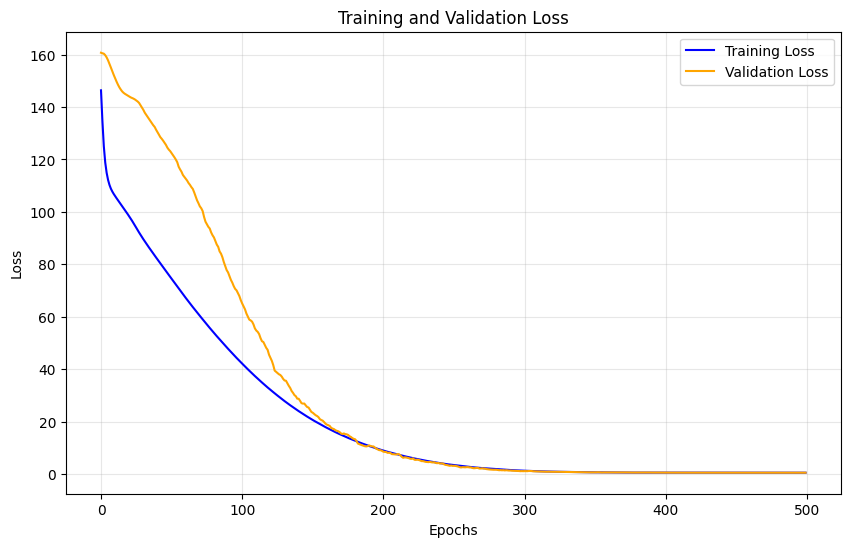

In [4]:
plot_loss(history)

# Prediction & Performance

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [6]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

model = tf.keras.models.load_model('/home/user/workdir/main/src/model/pm25/2013data/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test])
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 288ms/step


In [7]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [8]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

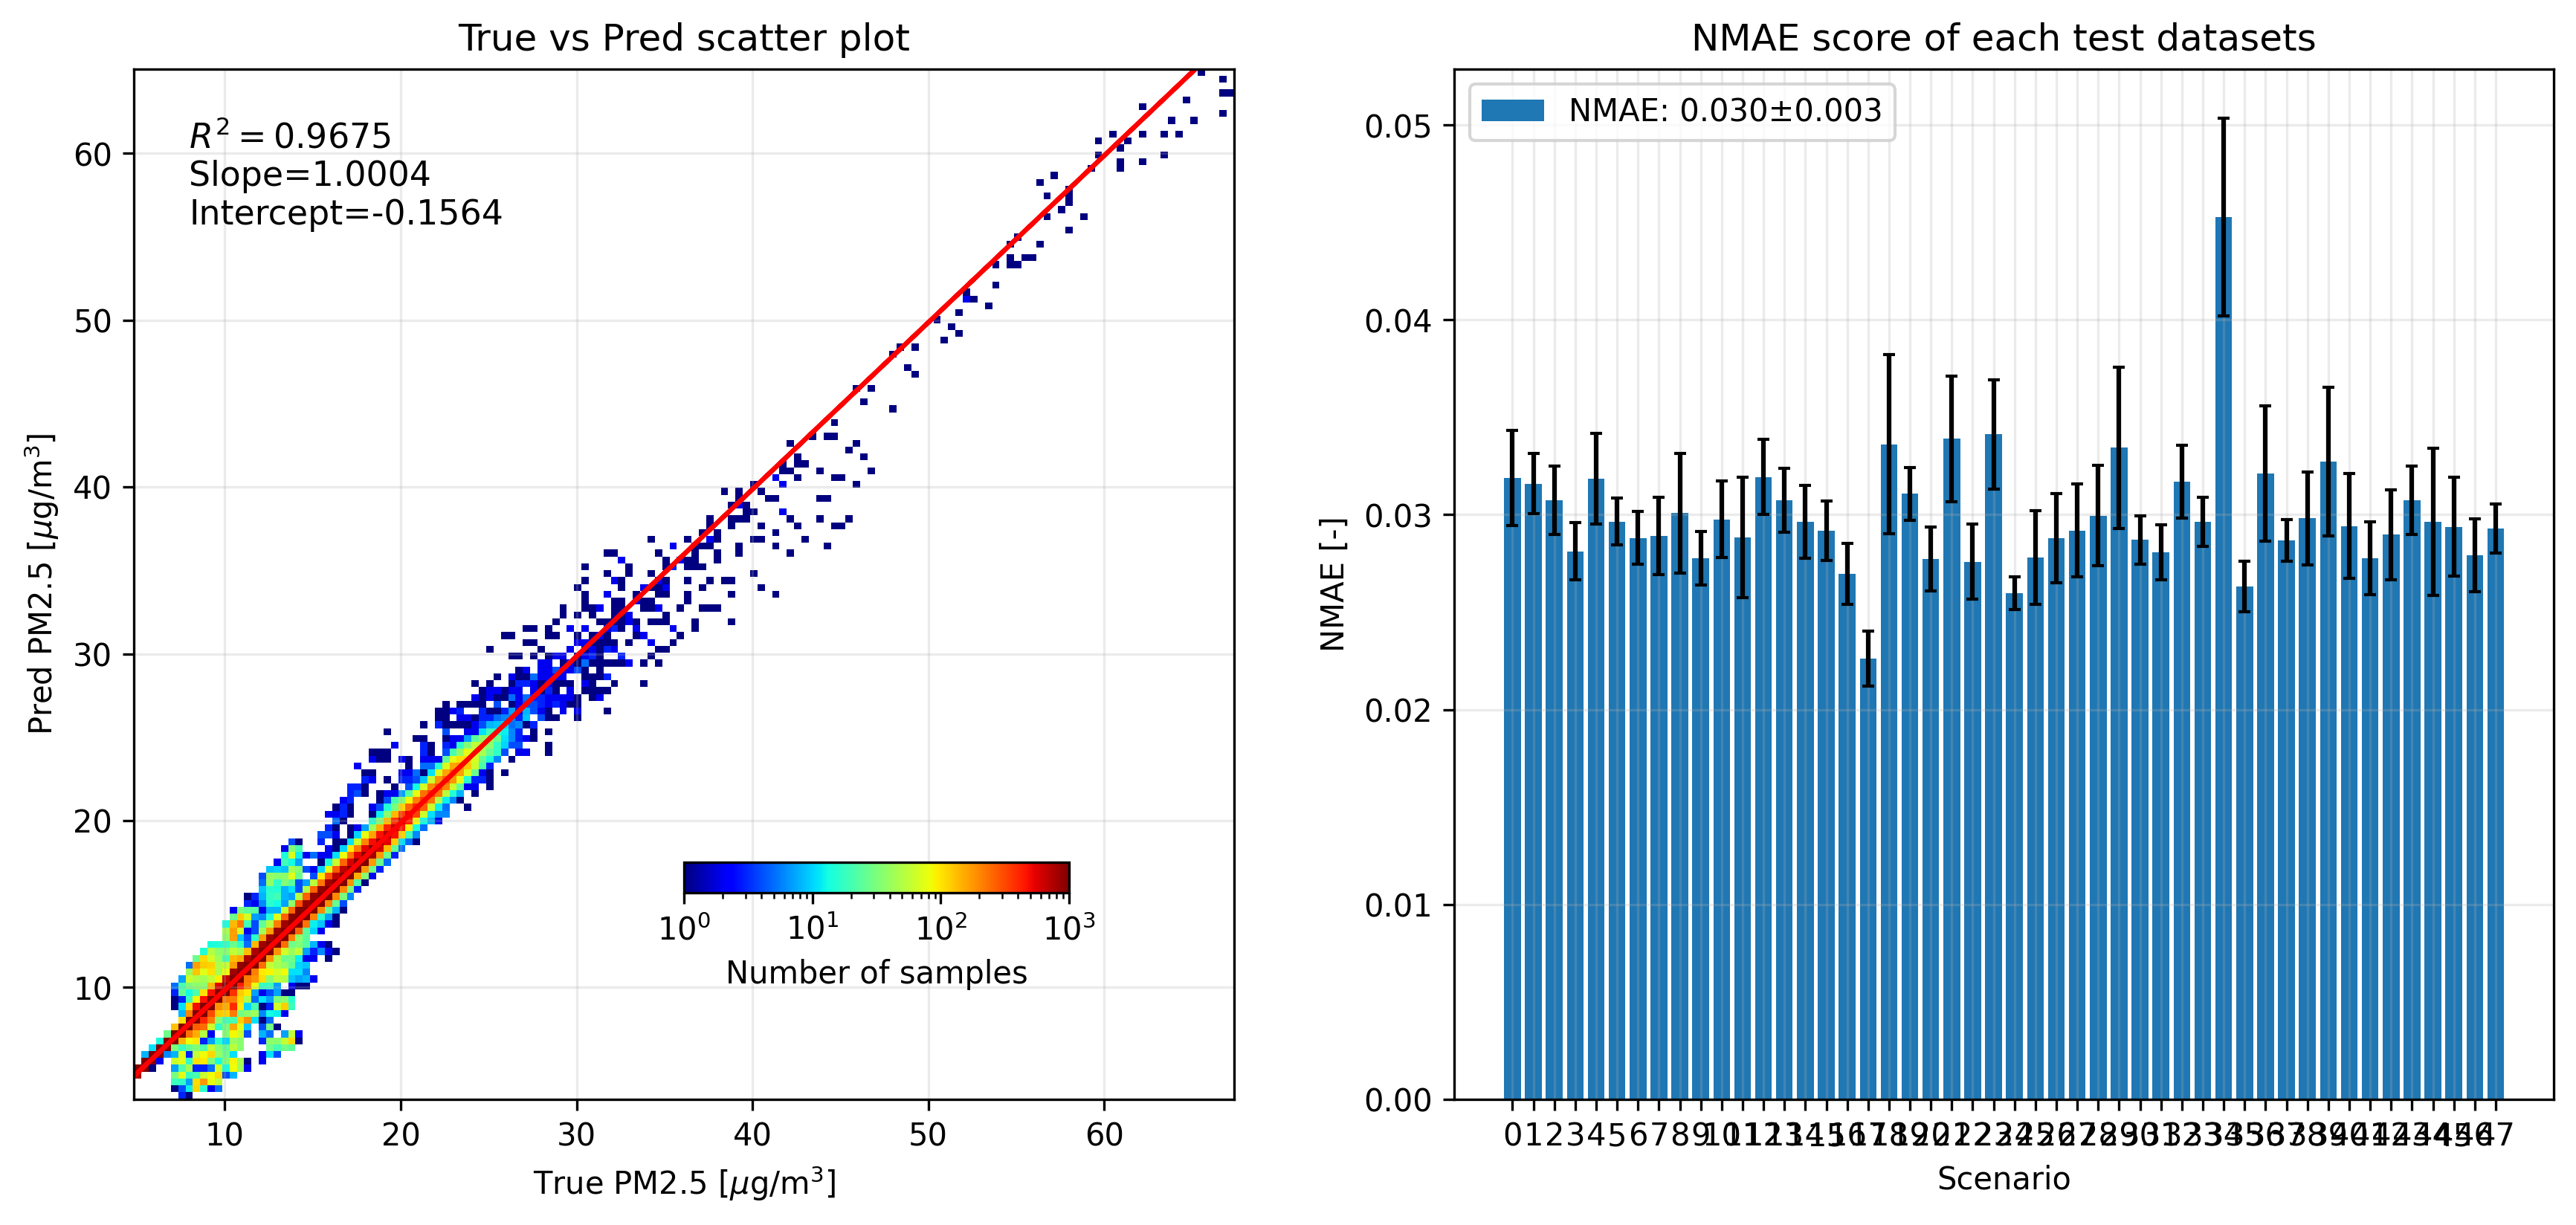

In [9]:
y_pred_ori = y_pred.reshape(-1)
y_true_ori = y_true.reshape(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_ori, y_pred_ori)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs Pred scatter plot")
axes[0].set_xlabel('True PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_ori = y_test.reshape(y_test.shape[0], -1)
y_pred_ori = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE score of each test datasets")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [-]')
plt.show()

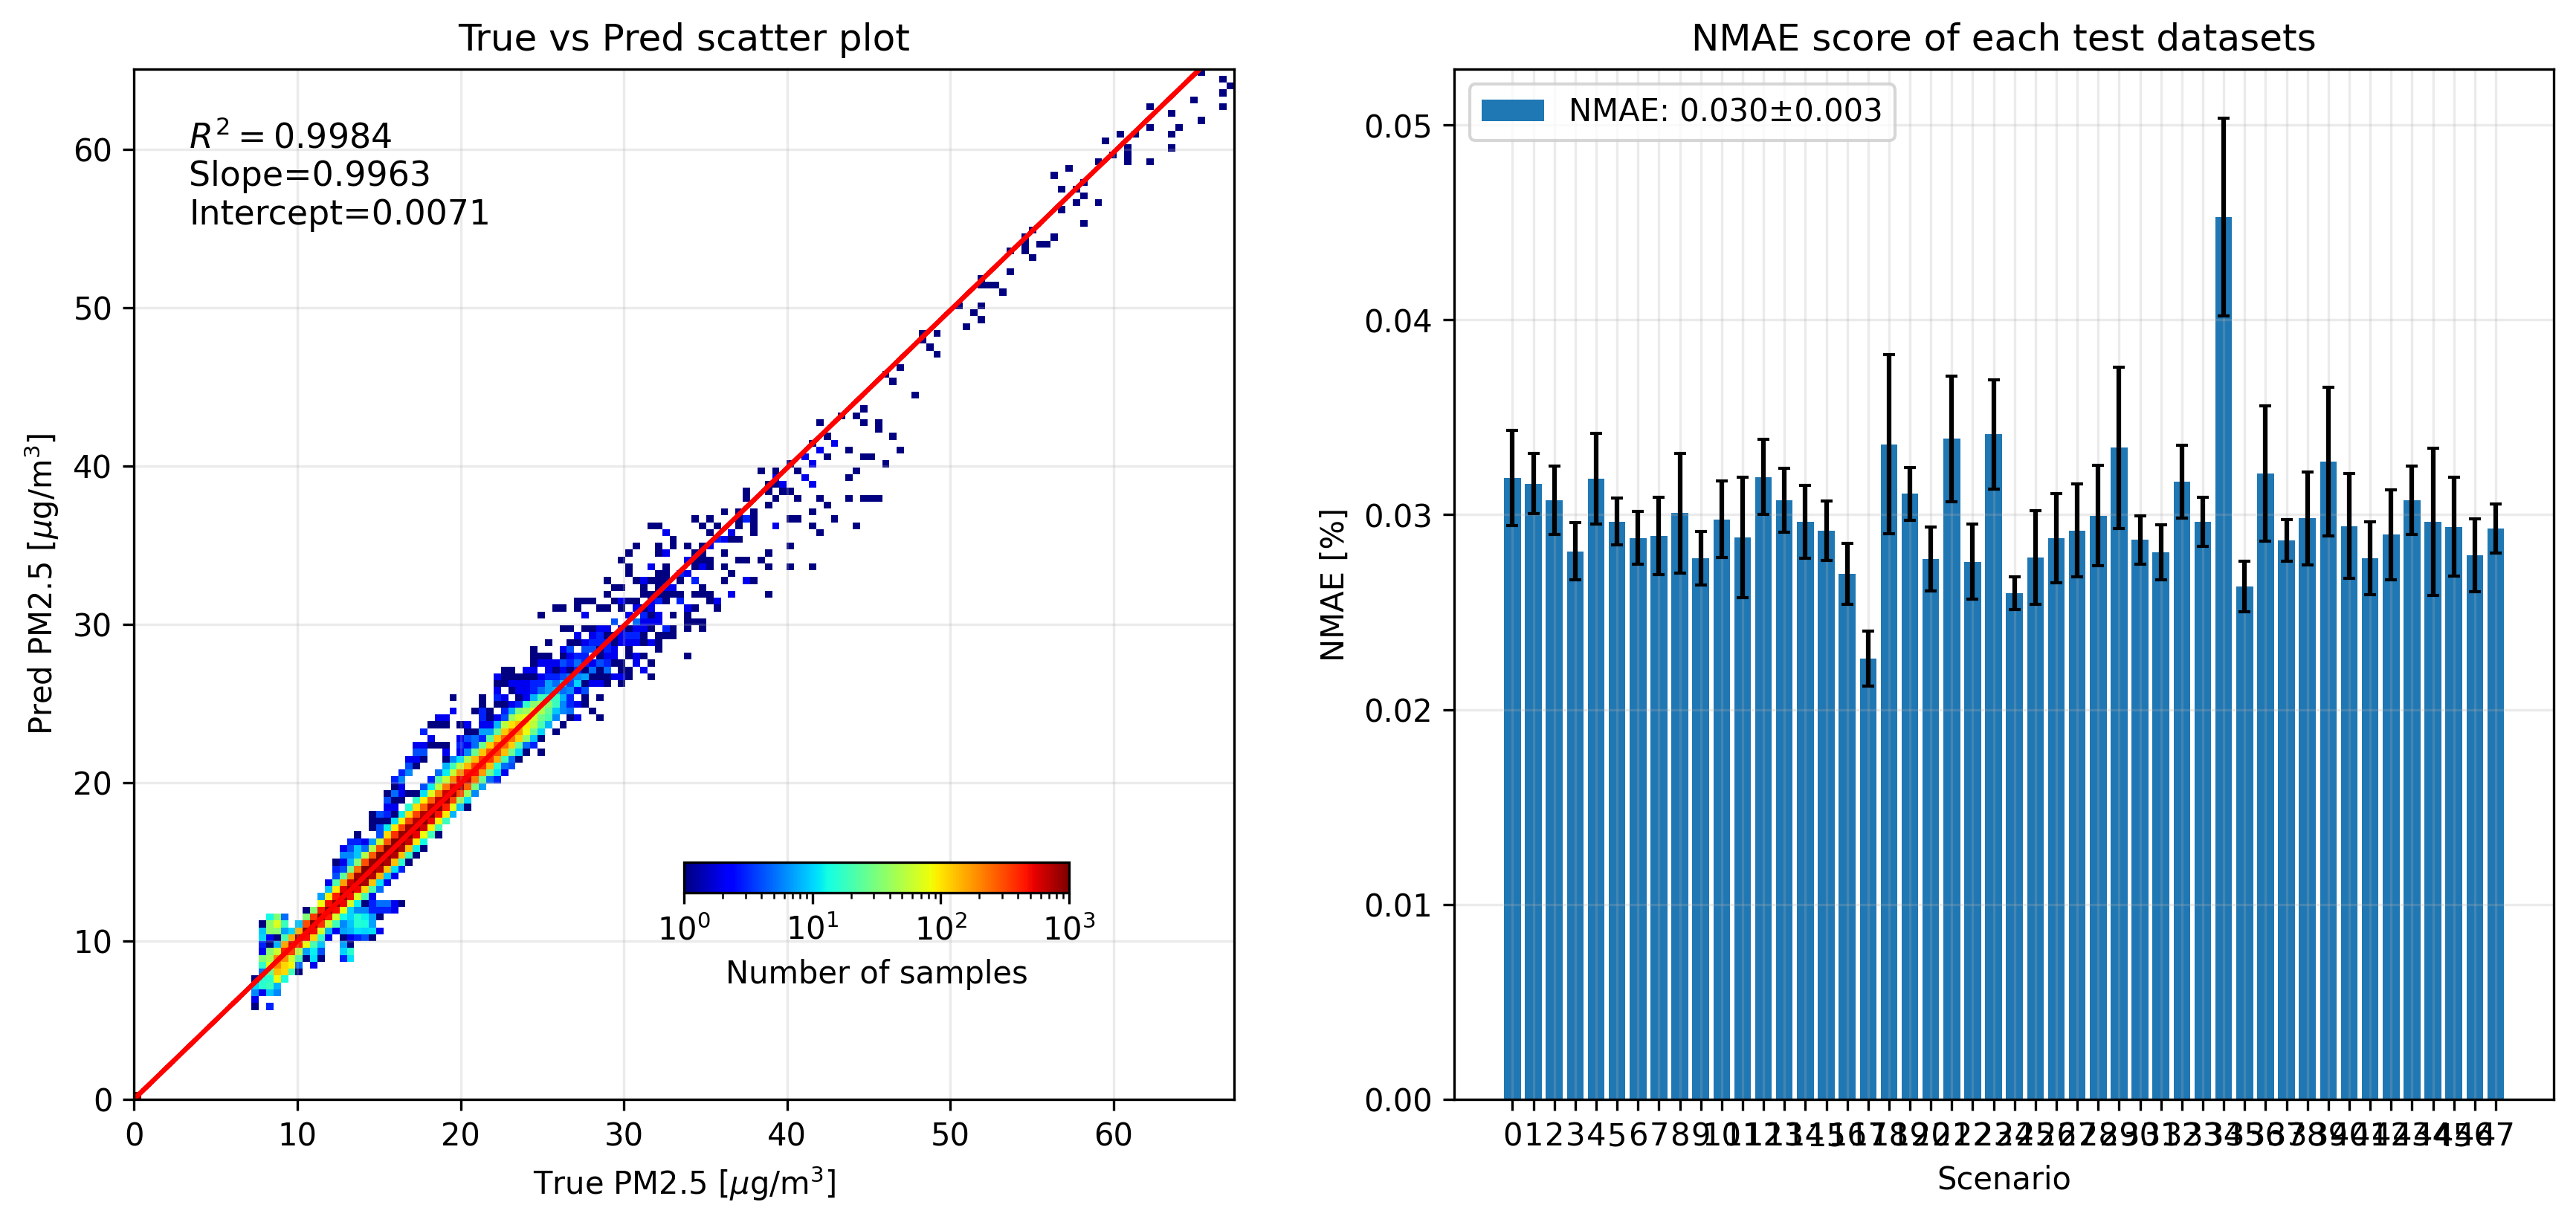

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
# axes[0].set_xlim(3, 67)  # True 축 범위를 조정
# axes[0].set_ylim(3, 69)  # Pred 축 범위를 조정
axes[0].set_title("True vs Pred scatter plot")
axes[0].set_xlabel('True PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_modi = y_test.reshape(y_test.shape[0], -1)
y_pred_modi = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true_modi, y_pred_modi)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE score of each test datasets")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

In [11]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


[15]


/tmp/ipykernel_1033694/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1033694/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1033694/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1033694/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1033694/3432564490.py:62: UserWarning: set_ti

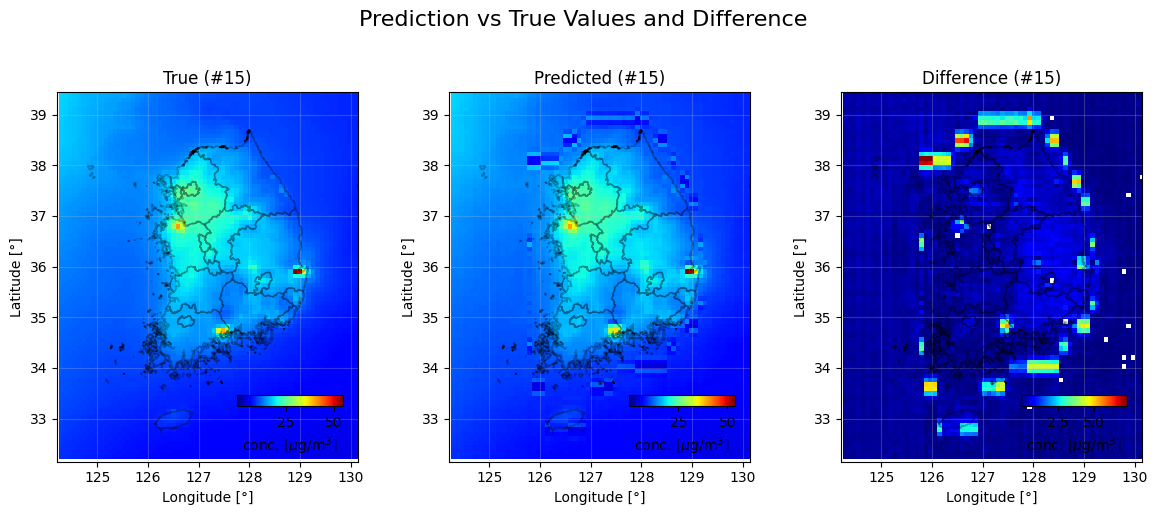

[34]


/tmp/ipykernel_1033694/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1033694/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1033694/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1033694/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1033694/3432564490.py:62: UserWarning: set_ti

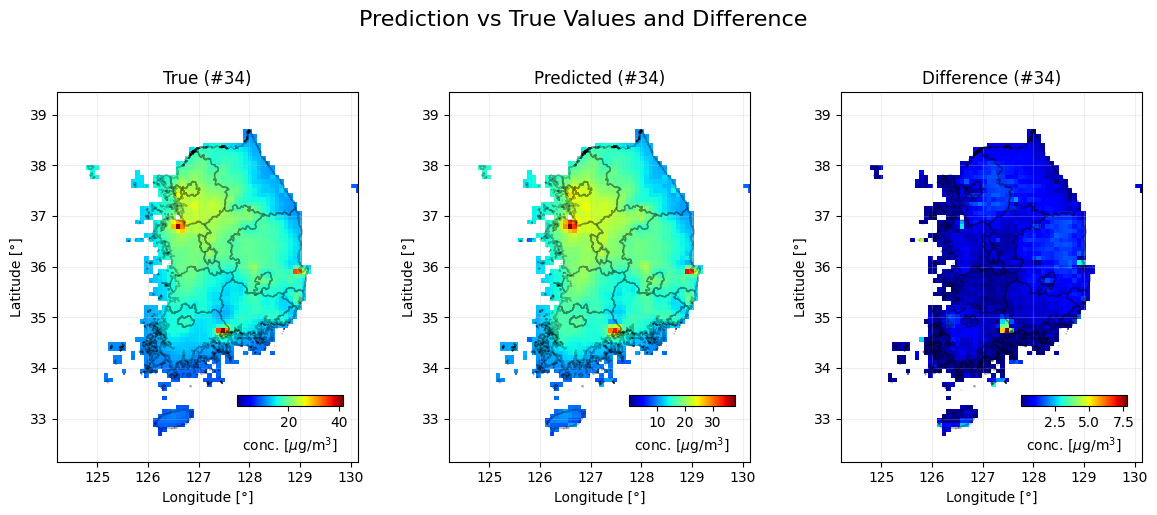

In [12]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

## GPU 메모리 할당 해제

In [13]:
tf.keras.backend.clear_session()